# Thông tin sinh viên nhóm 4

1. Bùi Đình Quân - 21522487

2. Nguyễn Trần Đình Quân - 21522499

3. Nguyễn Trần Hoàng Quân - 21522500


# Part 1 - Crawl data

In [ ]:
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import numpy as np

## 1 - Thu thập dữ liệu

### 1.1 Hàm lấy link sản phẩm

In [ ]:
def get_car_links(browser, num_of_pages):

    url = f'https://carvago.com/cars?fuel-type[]=diesel;ethanol;fueltype-other;lpg;petrol&number-of-seats-from=2&number-of-seats-to=7&page={num_of_pages}'
    browser.get(url)

    page = BeautifulSoup(browser.page_source, 'html.parser')
    findall = page.find_all(class_="css-6rwr0")


    links = []
    for item in findall:
        link_elements = item.find_all('a', href=True)
        for link in link_elements:
            href = 'https://carvago.com' + link['href']
            links.append(href)

    return links

### 1.2. Thu thập dữ liệu

In [ ]:
def extract_car_data(url, browser):
    browser.get(url)
    page_content = BeautifulSoup(browser.page_source, 'html.parser')

    # Danh sách lưu tên cột và giá trị
    column_names = []
    extracted_values = []

    # Trích xuất thông tin chi tiết
    detail_sections = page_content.select('div.css-12dtrl6')
    for section in detail_sections:
        items = section.select('div.css-j7qwjs')
        for item in items:
            label = item.select_one('p.chakra-text.css-1hkfmll')
            value = item.select_one('p.chakra-text.css-pvt509')
            if label and value:
                column_names.append(label.get_text(strip=True))
                extracted_values.append(value.get_text(strip=True))

    # Trích xuất thông tin chung
    general_section = page_content.select_one('div.css-1xuc798')
    if general_section:
        general_items = general_section.select('div.css-u863oz')
        for item in general_items:
            label = item.select_one('p.chakra-text.css-118f25i')
            value = item.select_one('p.chakra-text.css-y5aw9x')
            if label and value:
                column_names.append(label.get_text(strip=True))
                extracted_values.append(value.get_text(strip=True))

    # Trích xuất giá
    price_element = page_content.select_one("dl[data-testid='page.detail.primaryPrice'] dd.chakra-text.css-105xw8a")
    if price_element:
        price_text = price_element.get_text(strip=True)
        price_value = int(re.sub(r'[^\d]', '', price_text))
        column_names.append('Price')
        extracted_values.append(price_value)

    return column_names, extracted_values

In [ ]:
page_index = 1
target_car_count = 1000
car_columns = []
car_values = []
browser = webdriver.Edge()


while len(car_columns) < target_car_count:
    # Lấy danh sách liên kết của xe từ trang hiện tại
    car_links = get_car_links(browser, page_index)

    # Duyệt qua từng liên kết để trích xuất thông tin
    for i in range(len(car_links)):
        headers, data = extract_car_data(car_links[i], browser)
        car_columns.append(headers)
        car_values.append(data)

        # Kiểm tra xem đã đạt đủ số lượng xe cần thu thập chưa
        if len(car_columns) >= target_car_count:
            break

    # Tăng số trang
    page_index += 1

browser.close()

In [ ]:
print(len(car_columns))
print(len(car_values))

1000
1000


In [ ]:
for value in car_values:
    print(value)

['27\xa0000\xa0km', '7/2023', '129\xa0hp', 'Automatic', 'Diesel', '4x2', '5.2 l/100km', '102 g/km', 'Spain', '69324159', 'Citroën', 'C5 Aircross', 'Black', 'Metallic', 'Other interior color', 'Other interior material', 'SUV / offroad', '4/5 doors', '5', 22949]
['4\xa0500\xa0km', '9/2024', '211\xa0hp', 'Automatic', 'Petrol', '4x4', '6.5 l/100km', '146 g/km', 'Germany', '69324157', 'Nissan', 'X-Trail', 'Grey', 'Metallic', 'Black interior', 'Cloth interior', 'SUV / offroad', '4/5 doors', '5', 51649]
['9\xa0393\xa0km', '1/2024', '127\xa0hp', 'Manual', 'Petrol', '4x2', 'Netherlands', '69324074', 'Suzuki', 'SX4 S-Cross', 'Silver', 'Metallic', 'Other interior color', 'Full leather interior', 'SUV / offroad', '4/5 doors', '5', 28449]
['13\xa0300\xa0km', '6/2020', '90\xa0hp', 'Manual', 'Petrol', '4x2', '4.7 l/100km', '107 g/km', 'France', '69324070', 'Suzuki', 'Ignis', 'Black interior', 'Other interior material', 'SUV / offroad', '4/5 doors', '4', 15399]
['65\xa0140\xa0km', '1/2021', '129\xa0hp

### 1.3. Tạo header

In [ ]:
header = ['Make', 'Model', 'Location', 'First registration', 'Mileage', 'Power', 'Transmission', 'Fuel', 'Drive type', 'Consumption',
          'CO2 emissions', 'Body color', 'Interior color',  'Interior material', 'Body', 'Doors', 'Seats', 'Price']

### 1.4. Ánh xạ các giá trị của từng index đúng với từng header

In [ ]:
rows = [['' for _ in range(len(header))] for _ in range(len(car_columns))]

for i in range(len(car_columns)):
    for j in range(len(car_columns[i])):
        name = car_columns[i][j]
        value = car_values[i][j]
        if name in header:
            index = header.index(name)
            rows[i][index] = value

df = pd.DataFrame(rows, columns=header)

In [ ]:
df.head(10)

,Make,Model,Location,First registration,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats,Price
0,Citroën,C5 Aircross,Spain,7/2023,27 000 km,129 hp,Automatic,Diesel,4x2,5.2 l/100km,102 g/km,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors,5,22949
1,Nissan,X-Trail,Germany,9/2024,4 500 km,211 hp,Automatic,Petrol,4x4,6.5 l/100km,146 g/km,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors,5,51649
2,Suzuki,SX4 S-Cross,Netherlands,1/2024,9 393 km,127 hp,Manual,Petrol,4x2,,,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,5,28449
3,Suzuki,Ignis,France,6/2020,13 300 km,90 hp,Manual,Petrol,4x2,4.7 l/100km,107 g/km,,Black interior,Other interior material,SUV / offroad,4/5 doors,4,15399
4,Peugeot,Rifter,Poland,1/2021,65 140 km,129 hp,Manual,Diesel,4x2,5.3 l/100km,115 g/km,Grey,,,MPV/VAN,4/5 doors,7,30199
5,Seat,Ibiza,Germany,8/2021,105 075 km,109 hp,Manual,Petrol,4x2,4.9 l/100km,111 g/km,White,Black interior,Cloth interior,Hatchback,4/5 doors,5,15199
6,Kia,XCeed,Spain,7/2023,51 813 km,118 hp,Manual,Petrol,4x2,5.4 l/100km,124 g/km,White,Other interior color,Other interior material,SUV / offroad,4/5 doors,5,21049
7,Opel,Adam,Germany,11/2015,127 000 km,148 hp,Manual,Petrol,4x2,6.3 l/100km,144 g/km,,Black interior,Full leather interior,Hatchback,2/3 doors,4,10599
8,Volkswagen,Passat,Austria,8/2019,108 400 km,118 hp,Automatic,Diesel,4x2,5.3 l/100km,120 g/km,Grey,Black interior,Alcantara interior,Station Wagon,4/5 doors,5,18499
9,Audi,A4,Italy,11/2022,29 555 km,161 hp,Automatic,Diesel,4x2,4.1 l/100km,108 g/km,Black,Grey interior,Cloth interior,Station Wagon,4/5 doors,5,40499


In [ ]:
df.shape

(1000, 18)

### 1.5. Lưu dữ liệu

In [ ]:
df.to_csv('data_crawler_1.csv', index=False)

## 2 - Sau khi nhóm crawl dữ liệu xong, gộp dữ liệu lại thành 1 file.

In [ ]:
import pandas as pd

In [ ]:
df1 = pd.read_csv("data_crawler_1.csv")
df2 = pd.read_csv("data_crawler_2.csv")
df3 = pd.read_csv("data_crawler_3.csv")
df4 = pd.read_csv("data_crawler_4.csv")


In [ ]:
combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)


In [ ]:
combined_df

,Make,Model,Location,First registration,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats,Price
0,Mercedes-Benz,S 560,Germany,11/2019,110 200 km,463 hp,Automatic,Petrol,4x4,9.9 l/100km,225 g/km,Black,Beige interior,Full leather interior,Sedans / saloons,4/5 doors,5.0,88599.0
1,Audi,Q7,Poland,1/2024,1 km,282 hp,Automatic,Diesel,4x4,8 l/100km,182 g/km,Grey,NaN,Full leather interior,SUV / offroad,4/5 doors,5.0,88599.0
2,Porsche,991,Netherlands,2/2014,90 000 km,394 hp,Automatic,Petrol,4x2,9.5 l/100km,224 g/km,NaN,Other interior color,Part leather interior,Coupe,2/3 doors,4.0,88599.0
3,Mercedes-Benz,GLC 220,Spain,9/2024,2 001 km,194 hp,Automatic,Diesel,4x4,NaN,NaN,Silver,Other interior color,Other interior material,SUV / offroad,4/5 doors,5.0,88599.0
4,Mercedes-Benz,G 500,Austria,1/2017,72 470 km,416 hp,Automatic,Petrol,4x4,12.3 l/100km,289 g/km,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,5.0,88599.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3364,Lamborghini,Urus,Germany,9/2019,45 500 km,641 hp,Automatic,Petrol,4x4,13.6 l/100km,325 g/km,White,Other interior color,Full leather interior,SUV / offroad,4/5 doors,5.0,285849.0
3365,Volkswagen,Touareg,Germany,4/2024,24 430 km,228 hp,Automatic,Diesel,4x4,8.2 l/100km,184 g/km,Grey,Black interior,Full leather interior,SUV / offroad,4/5 doors,5.0,71199.0
3366,Škoda,Kodiaq,Germany,5/2024,3 000 km,190 hp,Automatic,Diesel,4x4,5.9 l/100km,149 g/km,Grey,Grey interior,Cloth interior,SUV / offroad,4/5 doors,5.0,55349.0
3367,Maserati,Levante,Germany,2/2019,68 000 km,424 hp,Automatic,Petrol,4x4,11.8 l/100km,282 g/km,Black,Black interior,Full leather interior,SUV / offroad,4/5 doors,5.0,59549.0


In [ ]:
combined_df.to_csv('data_crawler_final.csv', index=False)

# Part 2 - Data preprocessing - EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [ ]:
df = pd.read_csv('data_crawler_final.csv')

In [ ]:
df.shape

(5000, 18)

In [ ]:
df.head()

,Make,Model,Location,First registration,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats,Price
0,Citroën,C5 Aircross,Spain,7/2023,27 000 km,129 hp,Automatic,Diesel,4x2,5.2 l/100km,102 g/km,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors,5.0,22949.0
1,Nissan,X-Trail,Germany,9/2024,4 500 km,211 hp,Automatic,Petrol,4x4,6.5 l/100km,146 g/km,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors,5.0,51649.0
2,Suzuki,SX4 S-Cross,Netherlands,1/2024,9 393 km,127 hp,Manual,Petrol,4x2,NaN,NaN,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,5.0,28449.0
3,Suzuki,Ignis,France,6/2020,13 300 km,90 hp,Manual,Petrol,4x2,4.7 l/100km,107 g/km,NaN,Black interior,Other interior material,SUV / offroad,4/5 doors,4.0,15399.0
4,Peugeot,Rifter,Poland,1/2021,65 140 km,129 hp,Manual,Diesel,4x2,5.3 l/100km,115 g/km,Grey,NaN,NaN,MPV/VAN,4/5 doors,7.0,30199.0


## 1 - EDA before preprocess


In [ ]:
# prompt: write the funciton to plot pie chart. given the data and the title name. Plot top 5 most sample, the rest make it into "Other"

import pandas as pd
import matplotlib.pyplot as plt

def plot_pie_chart(data, title):
  """Plots a pie chart of the top 5 most frequent items in the data,
  grouping the rest into an "Other" category.

  Args:
    data: A pandas Series or list-like object containing the data to plot.
    title: The title of the pie chart.
  """

  value_counts = data.value_counts()

    # Lấy top 5 hãng xe
  top_5_values = value_counts.nlargest(5)

    # Tổng số lượng các hãng còn lại
  other_sum = value_counts.iloc[5:].sum()

    # Tạo danh sách nhãn
  labels = list(top_5_values.index)
  if other_sum > 0:
        labels.append("Other")

    # Tạo danh sách kích thước (số lượng)
  sizes = list(top_5_values.values)
  if other_sum > 0:
      sizes.append(other_sum)

    # Vẽ biểu đồ tròn
  plt.figure(figsize=(8, 8))
  plt.pie(
        sizes,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.Paired.colors  # Màu sắc tùy chọn
    )
  plt.title(title)
  plt.axis("equal")  # Giữ tỷ lệ hình tròn
  plt.show()

In [ ]:
def plot_bar_percent_count(data, text):
    # Tính phân phối của giá trị
    color_counts = data.value_counts()

    # Tính phân phối dưới dạng phần trăm
    color_percentages = color_counts / color_counts.sum() * 100

    # Vẽ biểu đồ cột chồng ngang
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = plt.barh(color_percentages.index, color_percentages, color=plt.cm.Paired.colors)

    # Thêm nhãn số lượng và phần trăm bên cạnh mỗi cột
    for bar in bars:
        xval = bar.get_width()
        count_label = int(xval / 100 * color_counts.sum())
        plt.text(xval + 1, bar.get_y() + bar.get_height() / 2, f'{count_label} - {xval:.1f}%', va='center')

    # Thêm nhãn và tiêu đề
    plt.xlabel('Số Lượng và Phần trăm')
    plt.ylabel(f'{text}')
    plt.title('Biểu đồ Cột Chồng Ngang với Số Lượng và Phần Trăm')
    plt.xticks(
        range(0, 101, 10),  # Điều chỉnh phạm vi để bao gồm từ 0 đến 100 với bước 10
        ['{:,.0f}%'.format(x) for x in range(0, 101, 10)]  # Điều chỉnh phạm vi và định dạng
    )
    # Đặt giới hạn trục x là 100%
    plt.xlim(0, 100)

    # Hiển thị biểu đồ
    plt.show()

### 1.1 Make

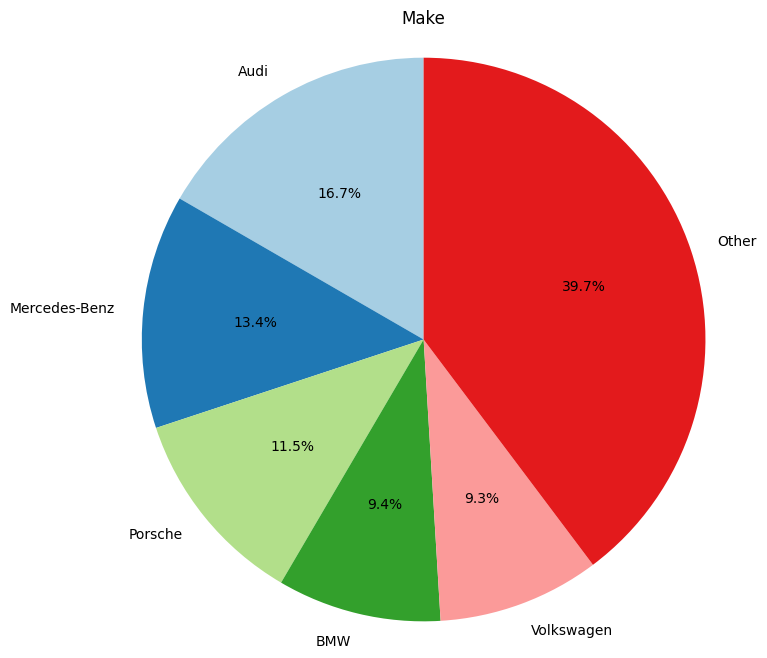

In [ ]:
plot_pie_chart(df['Make'], 'Make')

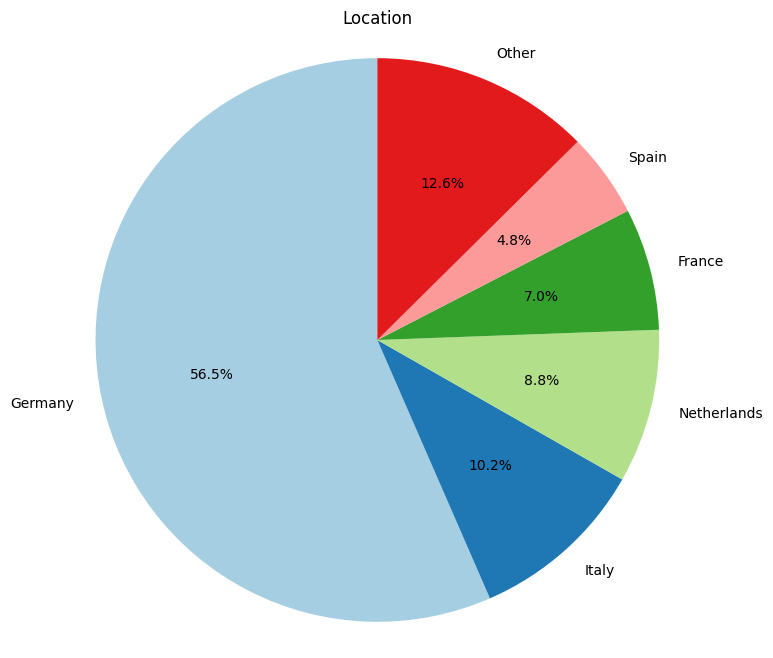

In [ ]:
plot_pie_chart(df['Location'], 'Location')

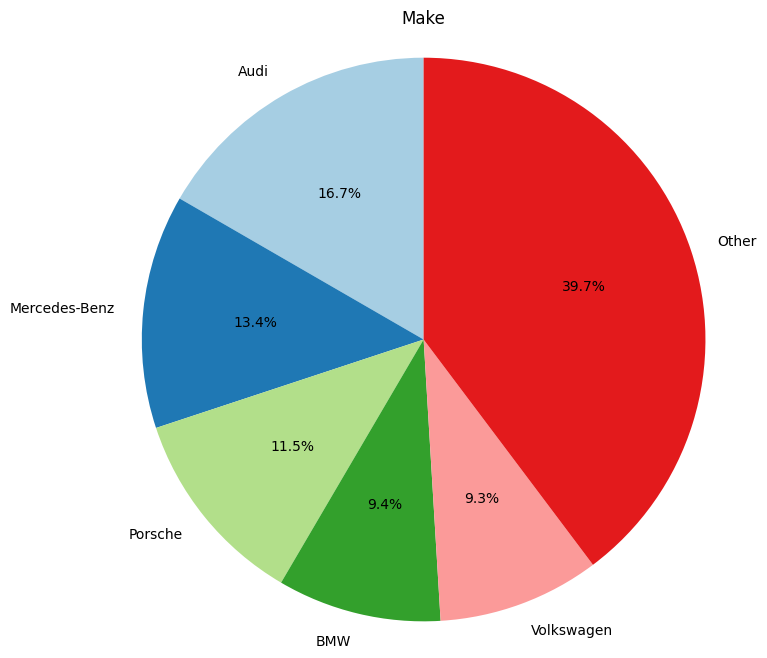

In [ ]:
plot_pie_chart(df['Make'], 'Make')

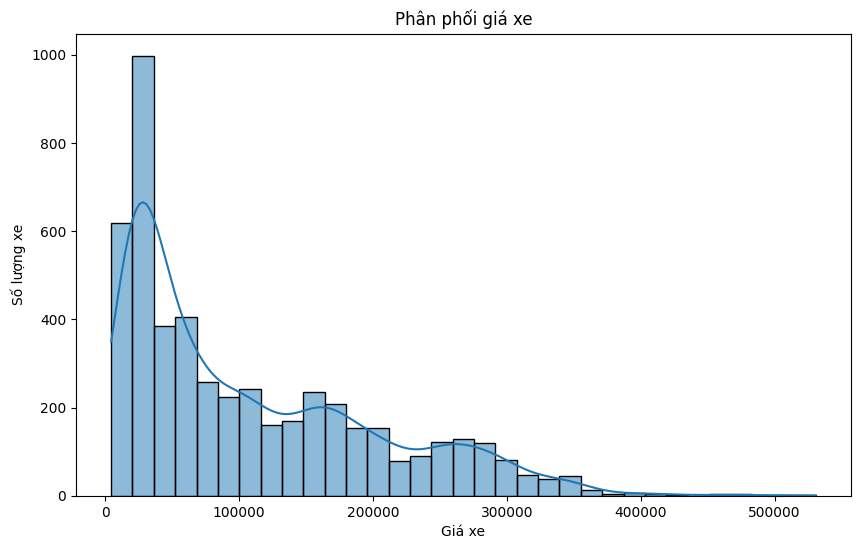

In [ ]:
# prompt: plot ra phạm vi của biến price

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Phân phối giá xe')
plt.xlabel('Giá xe')
plt.ylabel('Số lượng xe')
plt.show()

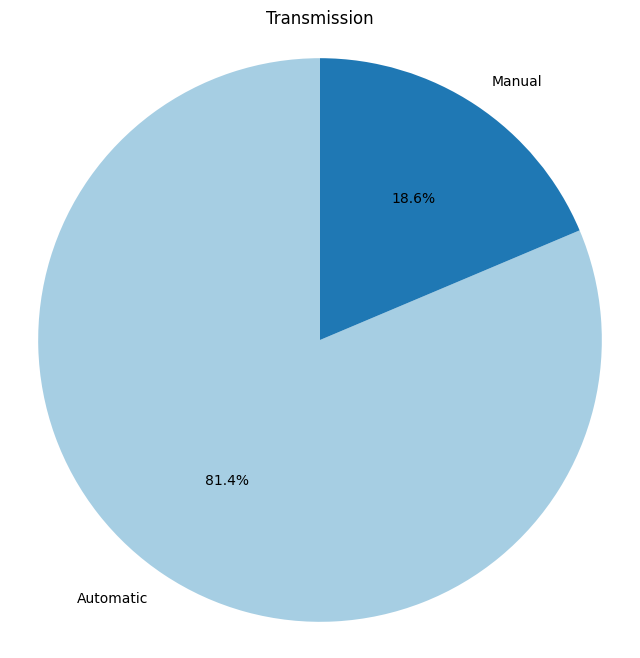

In [ ]:
plot_pie_chart(df['Transmission'], 'Transmission')

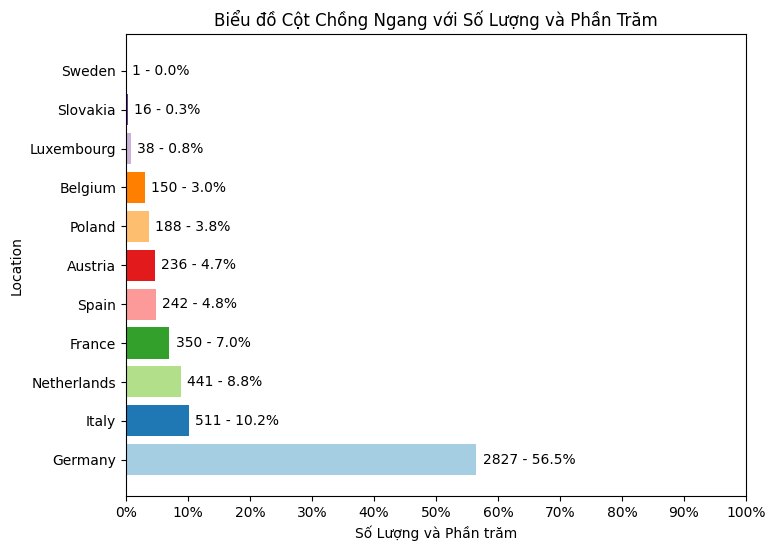

In [ ]:
plot_bar_percent_count(df['Location'], 'Location')

## 2 - Kiểm tra giá trị bị khuyết

### 2.1 Số lượng giá trị khuyết

In [ ]:
df.isna().sum()

,0
Make,0
Model,11
Location,0
First registration,0
Mileage,0
Power,0
Transmission,0
Fuel,0
Drive type,0
Consumption,810


Nhìn vào số lượng trên ta thấy số lượng khuyết của từng cột:
- Model: 11
- Consumption: 810
- CO2 emissions: 723
- Body color: 188
- Interior color: 311
- Interior material: 258
- Door: 9
- Còn lại các biến khác không có giá trị khuyết

In [ ]:
features_with_na = [features for features in df.columns if df[features].isnull().sum()>1]

for feature in features_with_na:
  print(feature, np.round(df[feature].isnull().mean(), 4), ' % missing values')

Model 0.0022  % missing values
Consumption 0.162  % missing values
CO2 emissions 0.1446  % missing values
Body color 0.0376  % missing values
Interior color 0.0622  % missing values
Interior material 0.0516  % missing values
Doors 0.0018  % missing values


### 2.2 Tìm mối quan hệ giữa các giá trị khuyết và giá xe

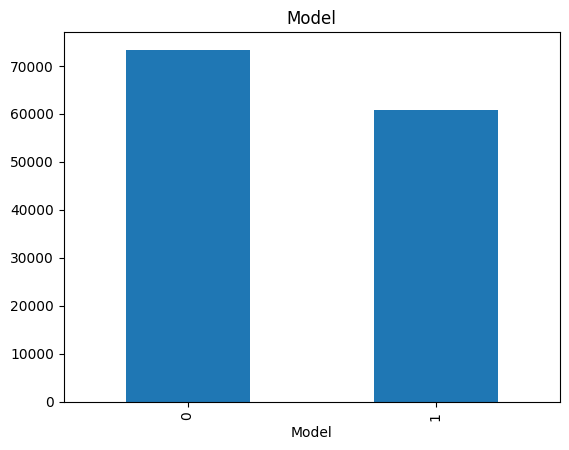

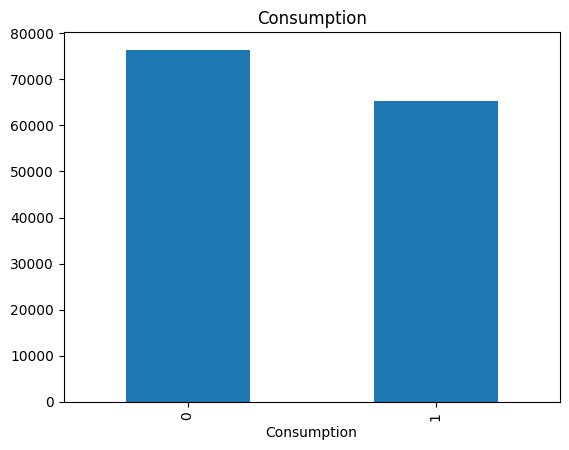

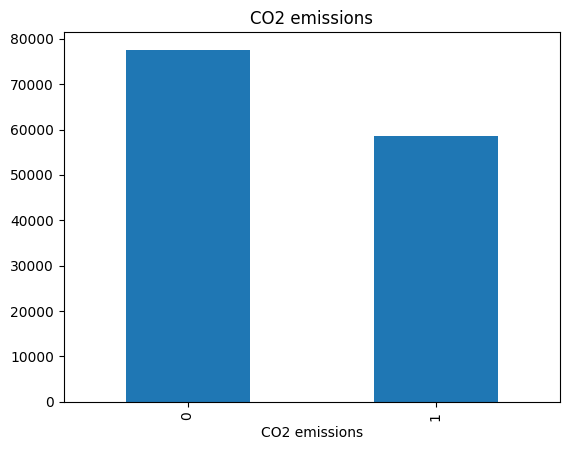

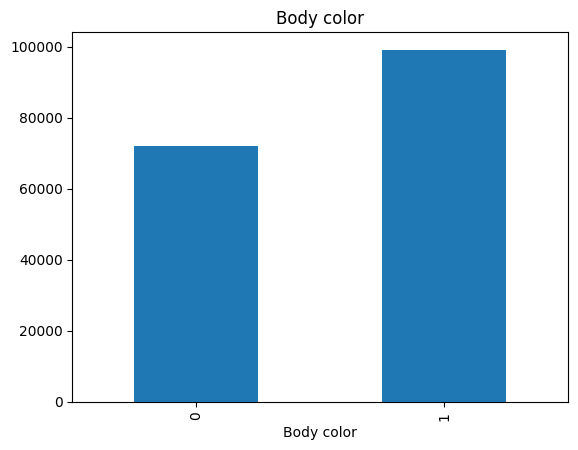

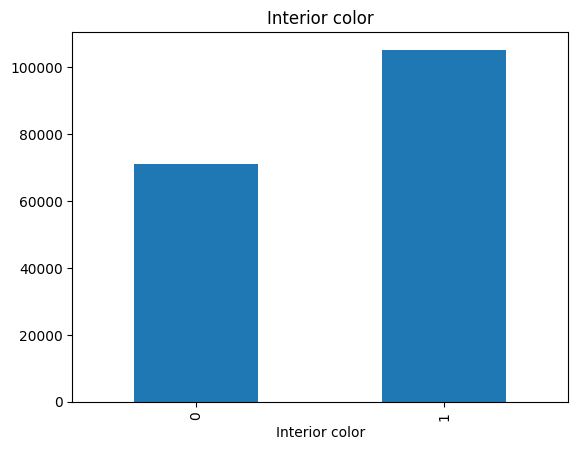

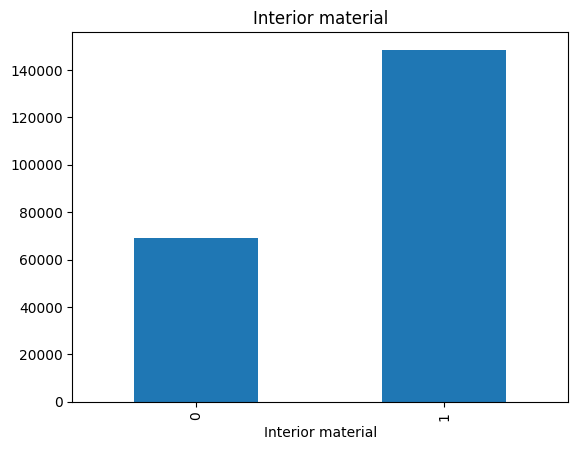

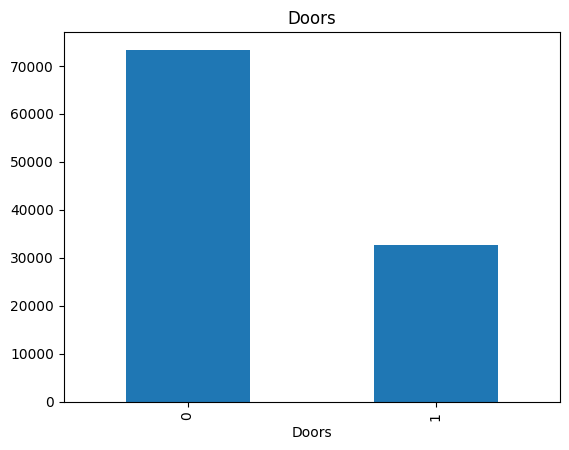

In [ ]:
for feature in features_with_na:
    data = df.copy()

    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    data[feature] = np.where(data[feature].isnull(), 1, 0)

    # let's calculate the mean SalePrice where the information is missing or present
    data.groupby(feature)['Price'].median().plot.bar()
    plt.title(feature)
    plt.show()

In [ ]:
print("Model of car {}".format(len(df.Model.unique())))

Model of car 492


## 3 - Kiểm tra kiểu dữ liệu và chuyển về kiểu dữ liệu thực tế

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Make                5000 non-null   object 
 1   Model               4989 non-null   object 
 2   Location            5000 non-null   object 
 3   First registration  5000 non-null   object 
 4   Mileage             5000 non-null   object 
 5   Power               5000 non-null   object 
 6   Transmission        5000 non-null   object 
 7   Fuel                5000 non-null   object 
 8   Drive type          5000 non-null   object 
 9   Consumption         4190 non-null   object 
 10  CO2 emissions       4277 non-null   object 
 11  Body color          4812 non-null   object 
 12  Interior color      4689 non-null   object 
 13  Interior material   4742 non-null   object 
 14  Body                5000 non-null   object 
 15  Doors               4991 non-null   object 
 16  Seats 

In [ ]:
# Sau khi thu thập dữ liệu, nhóm mong muốn kiểu dữ liệu thực tế của các thuộc tính như sau:
actual_dtypes = {
    'Make'                : 'object',
    'Model'               : 'object',
    'Location'            : 'object',
    'First registration'  : 'int64', # Chỉ chứa năm
    'Mileage'             : 'int64',
    'Power'               : 'int64',
    'Transmission'        : 'object',
    'Fuel'                : 'object',
    'Drive type'          : 'object',
    'Consumption'         : 'float64',
    'CO2 emissions'       : 'int64',
    'Body color'          : 'object',
    'Interior color'      : 'object',
    'Interior material'   : 'object',
    'Body'                : 'object',
    'Doors'               : 'object',
    'Seats'               : 'int64',
    'Price'               : 'int64'
}

In [ ]:
# Lấy kiểu dữ liệu pandas của các biến và lưu vào dictionary
pd_dtypes = df.dtypes.to_dict()
pd_dtypes = {col: str(dtype) for col, dtype in df.dtypes.items()}

# So sánh 2 kiểu dữ liệu
data = []
for key in actual_dtypes:
    prediction = actual_dtypes[key] == pd_dtypes[key]
    data.append([key, actual_dtypes[key], pd_dtypes[key], prediction])

# In kết quả so sánh kiểu dữ liệu thực tế và kiểu dữ liệu pandas
columns = ['Tên biến', 'Kiểu dữ liệu thực tế', 'Kiểu dữ liệu pandas', 'Dự đoán']
df_comparison = pd.DataFrame(data, columns=columns)
df_comparison

,Tên biến,Kiểu dữ liệu thực tế,Kiểu dữ liệu pandas,Dự đoán
0,Make,object,object,True
1,Model,object,object,True
2,Location,object,object,True
3,First registration,int64,object,False
4,Mileage,int64,object,False
5,Power,int64,object,False
6,Transmission,object,object,True
7,Fuel,object,object,True
8,Drive type,object,object,True
9,Consumption,float64,object,False


### 3.1 Make

In [ ]:
df['Make'].unique()

array(['Citroën', 'Nissan', 'Suzuki', 'Peugeot', 'Seat', 'Opel',
       'Volkswagen', 'Audi', 'Mazda', 'Porsche', 'Kia', 'Fiat', 'Renault',
       'Ford', 'BMW', 'Cupra', 'DS Automobiles', 'Mercedes-Benz', 'MINI',
       'Hyundai', 'Škoda', 'Dacia', 'Jeep', 'Maserati', 'Volvo', 'Toyota',
       'Jaguar', 'DR Automobiles', 'Lamborghini', 'Mitsubishi',
       'Land Rover', 'Dodge', 'Aixam', 'Subaru', 'MG', 'Alfa Romeo',
       'Honda', 'SsangYong', 'RAM', 'Mahindra', 'Abarth', 'Isuzu',
       'Bentley', 'Chevrolet', 'Ferrari', 'Aston Martin', 'McLaren',
       'Alpina', 'GMC', 'Rolls-Royce', 'Alpine', 'Cadillac', 'Lexus',
       'Ineos', 'Lotus', 'Morgan'], dtype=object)

### 3.2 Model

In [ ]:
df['Model'].unique()

array(['C5 Aircross', 'X-Trail', 'SX4 S-Cross', 'Ignis', 'Rifter',
       'Ibiza', 'Adam', 'Passat', 'A4', 'A1', 'CX-5', '992', 'Ceed',
       'Swift', 'Juke', 'Golf', '500C', 'Trafic', 'Taigo', 'XCeed',
       'Fiesta', 'A6', 'CX-30', '116', 'Leon', 'Punto', '430',
       '430 Gran Coupé', 'DS7 Crossback', 'Kuga', 'Tiguan', 'E 300',
       'Sportage', 'Tourneo Connect', 'Focus', 'Cooper S', 'Ateca',
       'Caddy', '530', 'i30', 'T-Cross', 'A 35 AMG', 'Qashqai', 'Clio',
       'Superb', 'MX-5', 'Transit Custom', 'M135', 'Sandero', 'Polo',
       'Movano', '320', '118', 'GLC 300', 'Astra', 'Compass', '991',
       'Levante', 'A3', 'XC60', 'T-Roc', 'Proace', 'F-Pace', 'M5',
       'Fabia', 'Q3', 'T6 Transporter', '4', 'Tiguan Allspace', 'Urus',
       'Stonic', '3', 'Kodiaq', 'Aygo', 'Eclipse Cross', '208', 'CLA 250',
       'Q5', 'X2', 'Colt', 'T6 California', 'V60 Cross Country', 'X5 M',
       'A 180', 'Grecale', '308', 'Discovery Sport', 'Charger', 'Austral',
       '500', 'S 350', 

### 3.3 Location

In [ ]:
df['Location'].unique()

array(['Spain', 'Germany', 'Netherlands', 'France', 'Poland', 'Austria',
       'Italy', 'Luxembourg', 'Belgium', 'Slovakia', 'Sweden'],
      dtype=object)

### 3.4 First registration

In [ ]:
df['First registration'].unique()

array(['7/2023', '9/2024', '1/2024', '6/2020', '1/2021', '8/2021',
       '11/2015', '8/2019', '11/2022', '2/2024', '7/2024', '7/2020',
       '10/2024', '3/2023', '5/2020', '8/2024', '4/2024', '10/2020',
       '6/2021', '10/2023', '3/2024', '10/2018', '5/2024', '12/2022',
       '11/2024', '3/2018', '11/2019', '7/2019', '7/2021', '3/2021',
       '9/2022', '8/2020', '9/2020', '7/2017', '11/2020', '1/2019',
       '2/2021', '6/2019', '4/2020', '4/2021', '11/2021', '6/2024',
       '8/2022', '2/2014', '1/2018', '11/2023', '2/2016', '1/2023',
       '9/2015', '4/2014', '9/2021', '4/2019', '10/2021', '9/2023',
       '8/2023', '8/2014', '3/2017', '12/2019', '5/2023', '3/2020',
       '4/2022', '12/2015', '2/2020', '12/2023', '4/2023', '12/2020',
       '9/2019', '2/2023', '12/2021', '5/2018', '2/2022', '6/2016',
       '6/2023', '1/2020', '5/2022', '8/2018', '4/2018', '11/2013',
       '6/2022', '7/2022', '3/2022', '5/2021', '12/2017', '3/2019',
       '11/2011', '11/2018', '2/2015', '12

In [ ]:
df['First registration'] = pd.to_datetime(df['First registration'], errors='coerce').dt.year.astype('int64')

<ipython-input-137-513406e4701e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['First registration'] = pd.to_datetime(df['First registration'], errors='coerce').dt.year.astype('int64')


In [ ]:
df['First registration'].unique()

array([2023, 2024, 2020, 2021, 2015, 2019, 2022, 2018, 2017, 2014, 2016,
       2013, 2011, 2012])

Text(0.5, 1.0, 'Price vs month since first register')

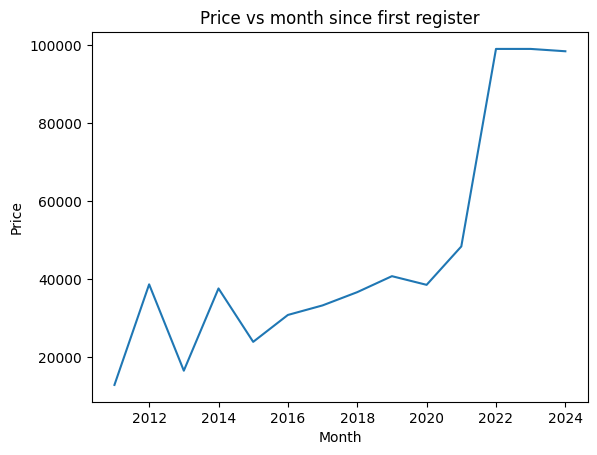

In [ ]:
df.groupby('First registration')['Price'].median().plot()
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Price vs month since first register')

**Note:**

- Xử lý First registration chỉ còn năm đăng ký

### 3.5 Mileage

In [ ]:
df['Mileage'].unique()

array(['27\xa0000\xa0km', '4\xa0500\xa0km', '9\xa0393\xa0km', ...,
       '19\xa0015\xa0km', '92\xa0km', '59\xa0560\xa0km'], dtype=object)

In [ ]:
df['Mileage'] = df['Mileage'].str.replace('\xa0', '')   # Thay ký hiệu '\xa0' thành ''
df['Mileage'] = df['Mileage'].str.replace('km', '')    # Thay ký hiệu ' km' thành ''
df['Mileage'] = df['Mileage'].astype('int64')

In [ ]:
df['Mileage'].unique()

array([27000,  4500,  9393, ..., 19015,    92, 59560])

**Note:**
- Loại bỏ các ký tự như `\xa0`, `km`, chỉ giữ lại số

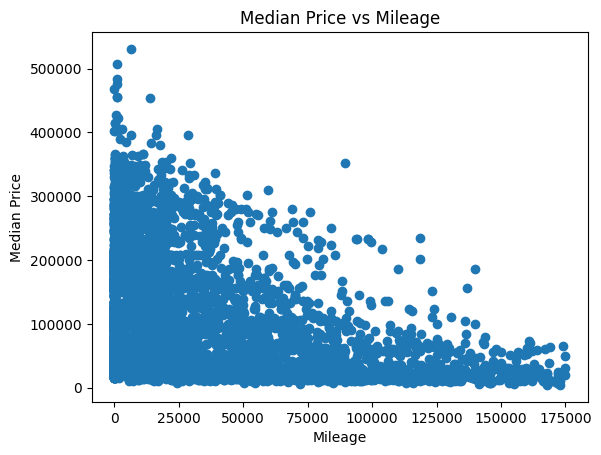

In [ ]:
plt.scatter(df['Mileage'], df['Price'])

plt.xlabel('Mileage')
plt.ylabel('Median Price')
plt.title('Median Price vs Mileage')
plt.show()

### 3.6 Power

In [ ]:
df['Power'].unique()

array(['129\xa0hp', '211\xa0hp', '127\xa0hp', '90\xa0hp', '109\xa0hp',
       '148\xa0hp', '118\xa0hp', '161\xa0hp', '192\xa0hp', '444\xa0hp',
       '138\xa0hp', '115\xa0hp', '68\xa0hp', '143\xa0hp', '94\xa0hp',
       '99\xa0hp', '261\xa0hp', '114\xa0hp', '241\xa0hp', '282\xa0hp',
       '177\xa0hp', '190\xa0hp', '158\xa0hp', '123\xa0hp', '201\xa0hp',
       '296\xa0hp', '121\xa0hp', '113\xa0hp', '302\xa0hp', '156\xa0hp',
       '66\xa0hp', '130\xa0hp', '103\xa0hp', '197\xa0hp', '188\xa0hp',
       '134\xa0hp', '255\xa0hp', '523\xa0hp', '142\xa0hp', '617\xa0hp',
       '276\xa0hp', '84\xa0hp', '98\xa0hp', '657\xa0hp', '83\xa0hp',
       '71\xa0hp', '74\xa0hp', '221\xa0hp', '150\xa0hp', '176\xa0hp',
       '394\xa0hp', '295\xa0hp', '300\xa0hp', '157\xa0hp', '612\xa0hp',
       '326\xa0hp', '181\xa0hp', '8\xa0hp', '306\xa0hp', '247\xa0hp',
       '154\xa0hp', '416\xa0hp', '194\xa0hp', '79\xa0hp', '166\xa0hp',
       '174\xa0hp', '184\xa0hp', '70\xa0hp', '503\xa0hp', '342\xa0hp',
      

In [ ]:
df['Power'] = df['Power'].str.replace('\xa0', '')   # Thay ký hiệu '\xa0' thành ''
df['Power'] = df['Power'].str.replace('hp', '')    # Thay ký kiệu 'hp' thành ''
df['Power'] = df['Power'].astype('int64')           # Chuyển về giá trị thực tế là 'int64'

In [ ]:
df['Power'].unique()

array([129, 211, 127,  90, 109, 148, 118, 161, 192, 444, 138, 115,  68,
       143,  94,  99, 261, 114, 241, 282, 177, 190, 158, 123, 201, 296,
       121, 113, 302, 156,  66, 130, 103, 197, 188, 134, 255, 523, 142,
       617, 276,  84,  98, 657,  83,  71,  74, 221, 150, 176, 394, 295,
       300, 157, 612, 326, 181,   8, 306, 247, 154, 416, 194,  79, 166,
       174, 184,  70, 503, 342, 204, 105, 208, 453,  75, 365, 160,  82,
       168,  80, 173, 217, 141,  89, 335, 233, 577,  64,  59, 573,  78,
       369,  62, 101, 349, 252, 429, 315, 207, 485, 329, 449, 304, 170,
       382, 339, 139, 209, 228, 512, 362, 153, 198, 185, 196, 345,  72,
       451, 375, 347, 110, 162, 237, 236, 248, 405, 500,  86, 434, 182,
       107, 496, 630,  97, 135, 443, 122, 469, 632, 178, 232, 202, 259,
       189, 355, 311, 542, 543, 330, 563, 133, 641,  91, 633, 707, 249,
       703, 616, 493, 145, 245,  95, 389, 380, 414, 323, 770, 200, 215,
       193, 288, 229, 251, 308, 137, 402, 440, 518, 456, 268, 12

**Note:**
- Loại bỏ các ký tự như `\xa0`, `hp`, chỉ giữ lại số
- Chuyển kiểu dữ liệu về kiểu int64

### 3.7 Transmission

In [ ]:
df['Transmission'].unique()

array(['Automatic', 'Manual'], dtype=object)

### 3.8 Fuel

In [ ]:
df['Fuel'].unique()

array(['Diesel', 'Petrol', 'LPG', 'Other fuel type', 'Hybrid', 'Ethanol'],
      dtype=object)

### 3.9 Drive type

In [ ]:
df['Drive type'].unique()

array(['4x2', '4x4'], dtype=object)

### 3.10 Consumption

In [ ]:
df['Consumption'].unique()

array(['5.2 l/100km', '6.5 l/100km', nan, '4.7 l/100km', '5.3 l/100km',
       '4.9 l/100km', '6.3 l/100km', '4.1 l/100km', '7.2 l/100km',
       '9.6 l/100km', '6.1 l/100km', '5.4 l/100km', '3.9 l/100km',
       '6.9 l/100km', '1.4 l/100km', '7 l/100km', '3.8 l/100km',
       '5 l/100km', '5.8 l/100km', '5.5 l/100km', '4.6 l/100km',
       '5.6 l/100km', '9 l/100km', '5.1 l/100km', '4.5 l/100km',
       '4.2 l/100km', '7.5 l/100km', '8.2 l/100km', '9.9 l/100km',
       '6 l/100km', '11.3 l/100km', '5.7 l/100km', '7.7 l/100km',
       '6.8 l/100km', '6.2 l/100km', '14.2 l/100km', '6.4 l/100km',
       '7.8 l/100km', '6.6 l/100km', '5.9 l/100km', '8.8 l/100km',
       '3.5 l/100km', '3.4 l/100km', '4.8 l/100km', '6.7 l/100km',
       '4 l/100km', '11.5 l/100km', '4.3 l/100km', '8.6 l/100km',
       '10.9 l/100km', '7.4 l/100km', '4.4 l/100km', '8 l/100km',
       '8.5 l/100km', '13.1 l/100km', '8.9 l/100km', '9.4 l/100km',
       '11.7 l/100km', '7.9 l/100km', '7.3 l/100km', '7.6 l/100k

In [ ]:
df['Consumption'] = df['Consumption'].str.replace(' l/100km', '')   # Thay ' l/100km' thành ''
df['Consumption'] = df['Consumption'].astype('float64')     # Chuyển về giá trị thực tế là 'float64'

In [ ]:
df['Consumption'].unique()

array([ 5.2,  6.5,  nan,  4.7,  5.3,  4.9,  6.3,  4.1,  7.2,  9.6,  6.1,
        5.4,  3.9,  6.9,  1.4,  7. ,  3.8,  5. ,  5.8,  5.5,  4.6,  5.6,
        9. ,  5.1,  4.5,  4.2,  7.5,  8.2,  9.9,  6. , 11.3,  5.7,  7.7,
        6.8,  6.2, 14.2,  6.4,  7.8,  6.6,  5.9,  8.8,  3.5,  3.4,  4.8,
        6.7,  4. , 11.5,  4.3,  8.6, 10.9,  7.4,  4.4,  8. ,  8.5, 13.1,
        8.9,  9.4, 11.7,  7.9,  7.3,  7.6,  3.3,  7.1, 15.2, 11.4,  9.1,
       11.8,  8.7, 12.8,  3.6,  8.1,  3.7, 10.4,  9.5, 11. , 10.2, 10.8,
        8.4, 12.5, 12.1,  1. , 10. ,  9.2, 11.6, 13.4,  3.2, 11.1,  8.3,
        9.8, 12.3,  2.5, 13.2, 10.7, 11.2,  9.7, 14.7,  9.3,  1.1, 10.6,
       10.1, 12. , 14.3, 13.3, 13.5, 14.1, 12.9, 13. , 13.6, 13.9, 14.9,
       12.6, 15.5, 16.7, 20.9, 14.5, 13.7, 13.8, 12.4, 12.7, 14. , 15.6,
       14.8, 16.1, 11.9, 14.6, 14.4, 12.2, 10.3, 16.2, 15. , 15.4, 16.4,
       10.5, 15.9, 20. ,  3.1,  2.1,  2.4, 15.3, 16.5])

**Note:**
- Loại bỏ các ký tự như ` l/100km`, ` `, chỉ giữ lại số
- Chuyển kiểu dữ liệu về float64

### 3.11 CO2 Emissions

In [ ]:
df['CO2 emissions'].unique()

array(['102 g/km', '146 g/km', nan, '107 g/km', '115 g/km', '111 g/km',
       '144 g/km', '120 g/km', '108 g/km', '112 g/km', '163 g/km',
       '220 g/km', '137 g/km', '124 g/km', '88 g/km', '174 g/km',
       '29 g/km', '160 g/km', '143 g/km', '101 g/km', '126 g/km',
       '128 g/km', '152 g/km', '142 g/km', '119 g/km', '121 g/km',
       '175 g/km', '122 g/km', '130 g/km', '154 g/km', '114 g/km',
       '117 g/km', '109 g/km', '165 g/km', '158 g/km', '140 g/km',
       '216 g/km', '141 g/km', '225 g/km', '147 g/km', '118 g/km',
       '157 g/km', '258 g/km', '135 g/km', '184 g/km', '176 g/km',
       '156 g/km', '325 g/km', '145 g/km', '116 g/km', '133 g/km',
       '95 g/km', '159 g/km', '94 g/km', '105 g/km', '125 g/km',
       '179 g/km', '113 g/km', '134 g/km', '129 g/km', '92 g/km',
       '151 g/km', '90 g/km', '110 g/km', '103 g/km', '188 g/km',
       '106 g/km', '148 g/km', '263 g/km', '34 g/km', '127 g/km',
       '98 g/km', '132 g/km', '169 g/km', '155 g/km', '131 g/km'

In [ ]:
df['CO2 emissions'] = df['CO2 emissions'].str.replace(' g/km', '')   # Thay ' g/km' thành ''
df['CO2 emissions'] = pd.to_numeric(df['CO2 emissions'], errors='coerce')
df['CO2 emissions'] = df['CO2 emissions'].astype('float64')

In [ ]:
df['CO2 emissions'].unique()

array([102., 146.,  nan, 107., 115., 111., 144., 120., 108., 112., 163.,
       220., 137., 124.,  88., 174.,  29., 160., 143., 101., 126., 128.,
       152., 142., 119., 121., 175., 122., 130., 154., 114., 117., 109.,
       165., 158., 140., 216., 141., 225., 147., 118., 157., 258., 135.,
       184., 176., 156., 325., 145., 116., 133.,  95., 159.,  94., 105.,
       125., 179., 113., 134., 129.,  92., 151.,  90., 110., 103., 188.,
       106., 148., 263.,  34., 127.,  98., 132., 169., 155., 131., 251.,
       162., 170., 123., 149., 100., 182., 199., 183.,  97., 202., 173.,
       104., 180., 185., 150., 195., 171.,  99., 257., 197., 138., 178.,
       168., 167., 161., 139., 166.,  86., 181., 187., 322.,  93., 215.,
       208., 267., 198., 298.,  89., 177., 201., 186., 209., 214.,  96.,
       247., 153., 193.,  87., 172., 238., 218.,  91., 205., 217., 248.,
       222., 191., 164., 284., 277., 136., 229., 268.,  26., 297., 253.,
       270., 319., 254., 223., 194., 189., 295.,  5

**Note:**
- Loại bỏ các ký tự như `g/km`, chỉ giữ lại số
- Và chuyển kiểu dữ liệu về float64 (do còn các giá trị NaN nên không thể chuyển về int64)

### 3.12 Body color

In [ ]:
df['Body color'].unique()

array(['Black', 'Grey', 'Silver', nan, 'White', 'Blue', 'Green', 'Red',
       'Brown', 'Beige', 'Orange', 'Gold', 'Yellow', 'Purple'],
      dtype=object)

### 3.13 Interior color

In [ ]:
df['Interior color'].unique()

array(['Other interior color', 'Black interior', nan, 'Grey interior',
       'Brown interior', 'Beige interior'], dtype=object)

### 3.14 Interior material

In [ ]:
df['Interior material'].unique()

array(['Other interior material', 'Cloth interior',
       'Full leather interior', nan, 'Alcantara interior',
       'Part leather interior', 'Velour interior'], dtype=object)

### 3.15 Body

In [ ]:
df['Body'].unique()

array(['SUV / offroad', 'MPV/VAN', 'Hatchback', 'Station Wagon', 'Coupe',
       'Cabriolet', 'Cargo VAN', 'Sedans / saloons', 'MPV', 'Pick-up'],
      dtype=object)

### 3.16 Doors

In [ ]:
df['Doors'].unique()

array(['4/5 doors', '2/3 doors', nan, '6/7 doors'], dtype=object)

### 3.17 Seats

In [ ]:
df['Seats'] = df['Seats'].astype('int64')           # Chuyển về giá trị thực tế là 'int64'

In [ ]:
df['Seats'].unique()

array([5, 4, 7, 6, 2, 3])

**Note:**
- Chuyển kiểu dữ liệu về kiểu int64

### 3.18 Price

In [ ]:
df['Price'].unique()

array([ 22949.,  51649.,  28449., ..., 310099., 310149., 309699.])

### 3.19 Mô tả các biến số

In [ ]:
df.describe()

,First registration,Mileage,Power,Consumption,CO2 emissions,Seats,Price
count,5000.00000,5000.000000,5000.000000,4190.000000,4277.000000,5000.000000,5000.000000
mean,2021.84940,32059.937200,332.742400,8.494606,196.433949,4.587200,108025.980000
std,2.45233,38792.569984,197.690815,3.271478,78.075403,1.081587,93089.318524
min,2011.00000,0.000000,8.000000,1.000000,15.000000,2.000000,4399.000000
25%,2020.00000,1500.000000,148.000000,5.500000,124.000000,4.000000,29399.000000
50%,2023.00000,16255.000000,282.000000,7.700000,187.000000,5.000000,73324.000000
75%,2024.00000,48566.750000,523.000000,11.700000,263.000000,5.000000,167349.000000
max,2024.00000,175000.000000,797.000000,20.900000,499.000000,7.000000,530699.000000


## 4 - Numerical Variables

In [ ]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O' and feature not in ['Price']]

print('Number of numerical variables: ', len(numerical_features))

df[numerical_features].head()

Number of numerical variables:  6


,First registration,Mileage,Power,Consumption,CO2 emissions,Seats
0,2023,27000,129,5.2,102.0,5
1,2024,4500,211,6.5,146.0,5
2,2024,9393,127,NaN,NaN,5
3,2020,13300,90,4.7,107.0,4
4,2021,65140,129,5.3,115.0,7


Discrete variable

In [ ]:
discrete_feature=[feature for feature in numerical_features if len(df[feature].unique())<25 and feature not in ['Price', 'First registration']]
print("Discrete Variables Count: {}".format(len(discrete_feature)))
discrete_feature

Discrete Variables Count: 1


['Seats']

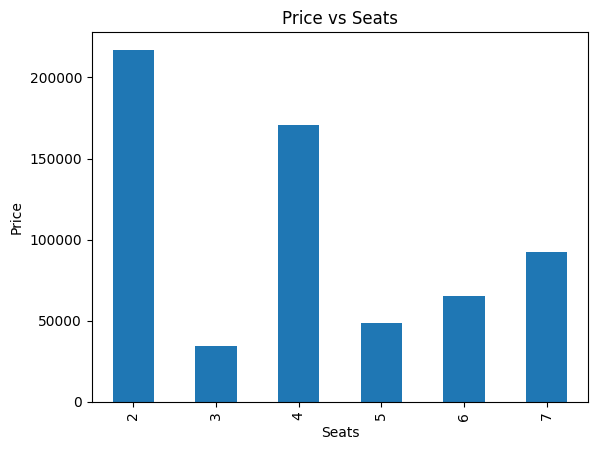

In [ ]:
data = df.copy()
data.groupby('Seats')['Price'].median().plot.bar()
plt.xlabel('Seats')
plt.ylabel('Price')
plt.title('Price vs Seats')
plt.show()

## 5 - Continuous Variable

In [ ]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature+['First registration']]
print("Continuous feature Count {}".format(len(continuous_feature)))

Continuous feature Count 4


In [ ]:
df[continuous_feature]

,Mileage,Power,Consumption,CO2 emissions
0,27000,129,5.2,102.0
1,4500,211,6.5,146.0
2,9393,127,NaN,NaN
3,13300,90,4.7,107.0
4,65140,129,5.3,115.0
...,...,...,...,...
4995,92,606,11.4,272.0
4996,59560,691,NaN,NaN
4997,92,606,11.9,269.0
4998,4500,671,12.2,276.0


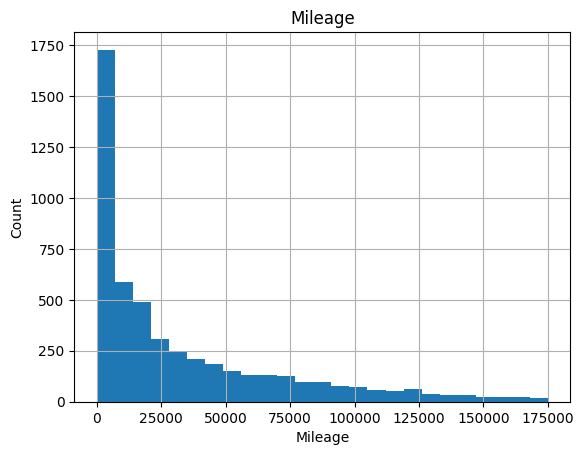

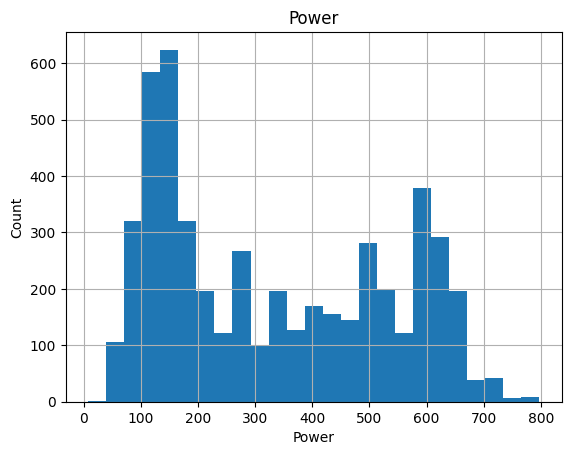

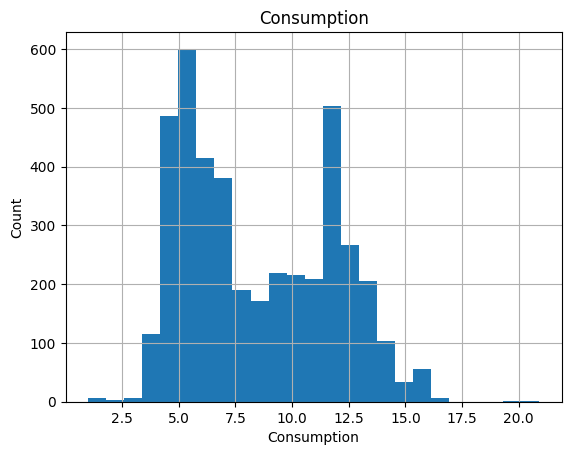

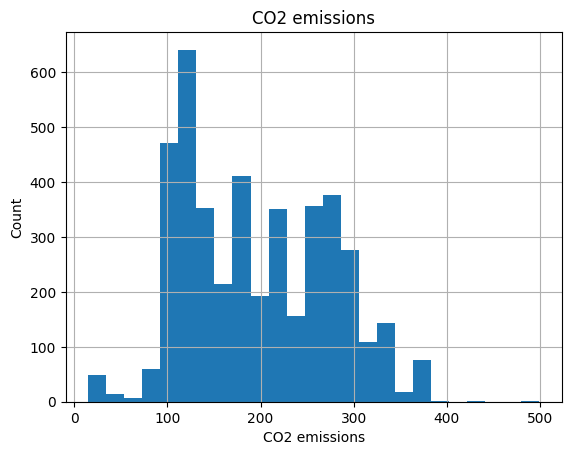

In [ ]:
for feature in continuous_feature:
    data=df.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

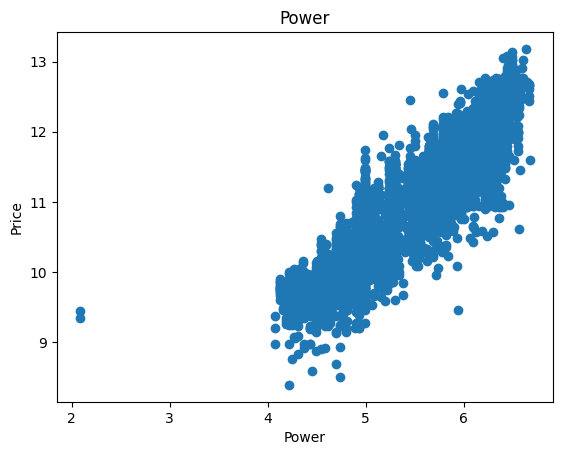

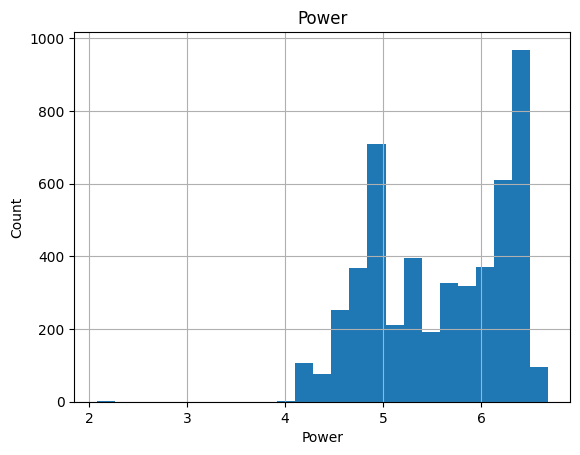

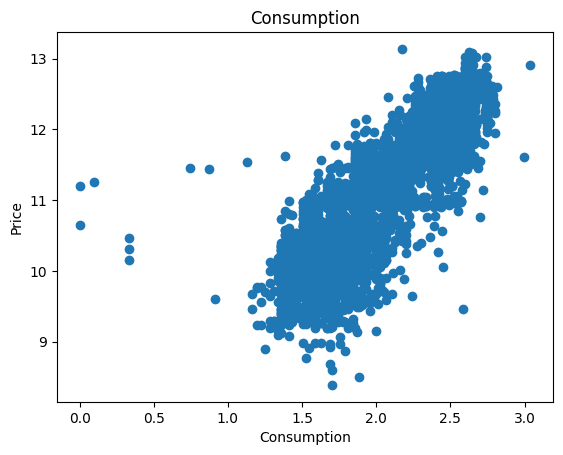

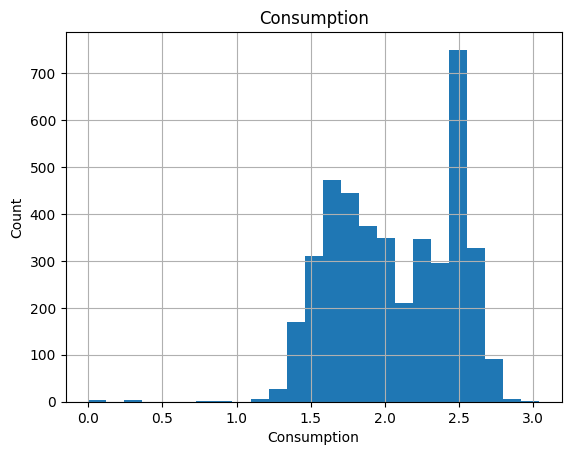

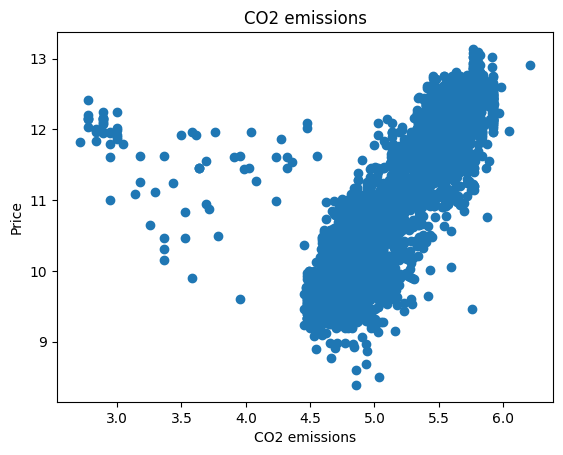

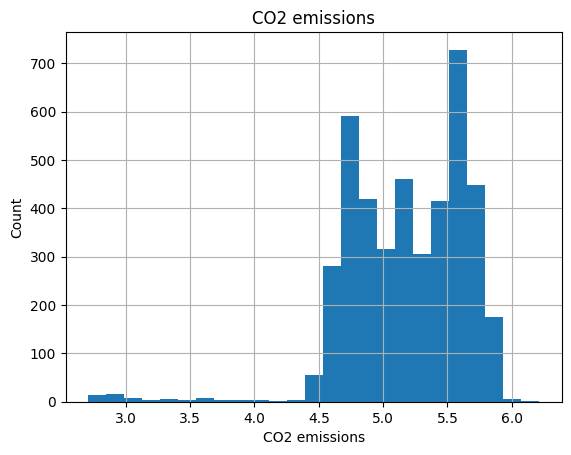

In [ ]:
# Logarithmic transformation

for feature in continuous_feature:
    data=df.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature]=np.log(data[feature])
        data['Price']=np.log(data['Price'])
        plt.scatter(data[feature],data['Price'])
        plt.xlabel(feature)
        plt.ylabel('Price')
        plt.title(feature)
        plt.show()

        data[feature].hist(bins=25)
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.title(feature)
        plt.show()


### Outliers

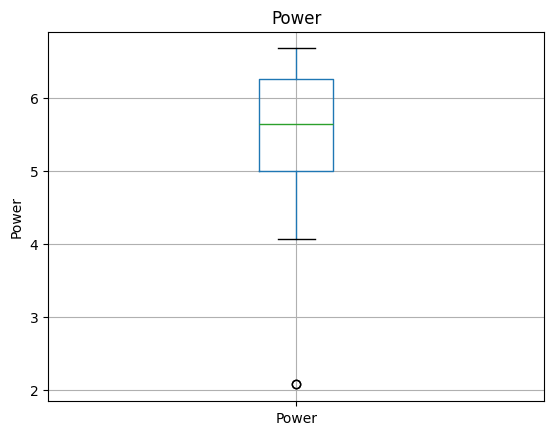

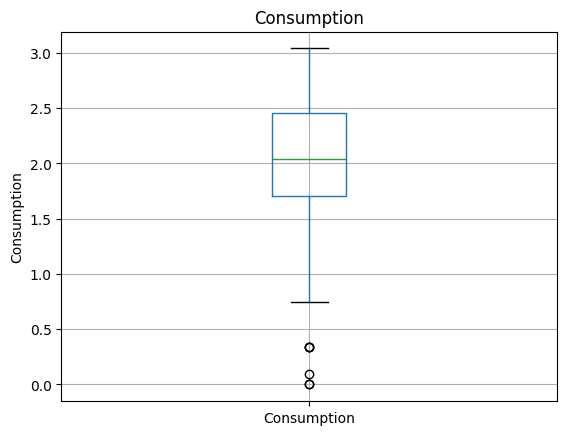

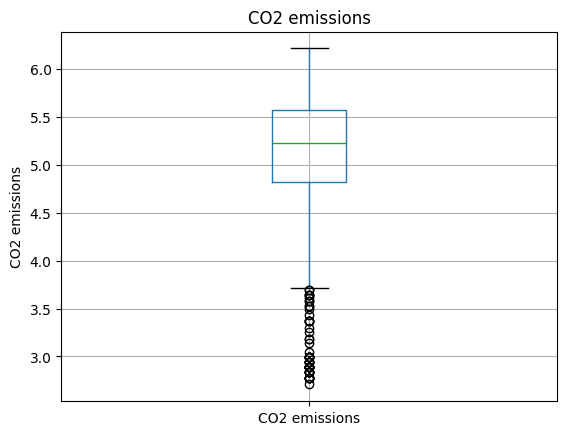

In [ ]:
for feature in continuous_feature:
    data=df.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature]=np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

## 6 - Categorical Vairiables

In [ ]:
categorical_features=[feature for feature in df.columns if data[feature].dtypes=='O']
categorical_features

['Make',
 'Model',
 'Location',
 'Transmission',
 'Fuel',
 'Drive type',
 'Body color',
 'Interior color',
 'Interior material',
 'Body',
 'Doors']

In [ ]:
df[categorical_features].head()

,Make,Model,Location,Transmission,Fuel,Drive type,Body color,Interior color,Interior material,Body,Doors
0,Citroën,C5 Aircross,Spain,Automatic,Diesel,4x2,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors
1,Nissan,X-Trail,Germany,Automatic,Petrol,4x4,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors
2,Suzuki,SX4 S-Cross,Netherlands,Manual,Petrol,4x2,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors
3,Suzuki,Ignis,France,Manual,Petrol,4x2,NaN,Black interior,Other interior material,SUV / offroad,4/5 doors
4,Peugeot,Rifter,Poland,Manual,Diesel,4x2,Grey,NaN,NaN,MPV/VAN,4/5 doors


In [ ]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(df[feature].unique())))

The feature is Make and number of categories are 56
The feature is Model and number of categories are 492
The feature is Location and number of categories are 11
The feature is Transmission and number of categories are 2
The feature is Fuel and number of categories are 6
The feature is Drive type and number of categories are 2
The feature is Body color and number of categories are 14
The feature is Interior color and number of categories are 6
The feature is Interior material and number of categories are 7
The feature is Body and number of categories are 10
The feature is Doors and number of categories are 4


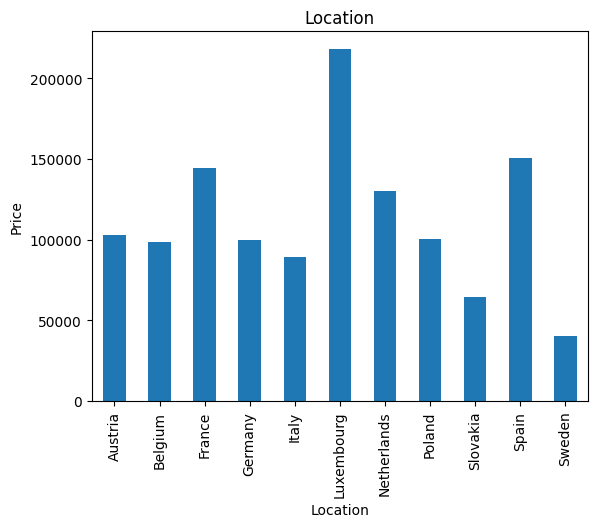

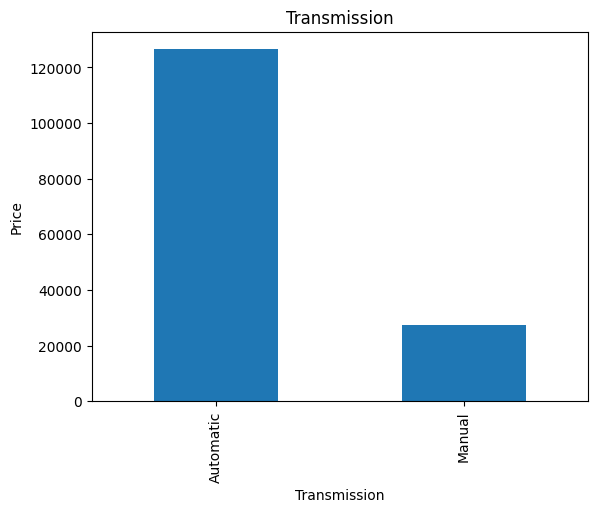

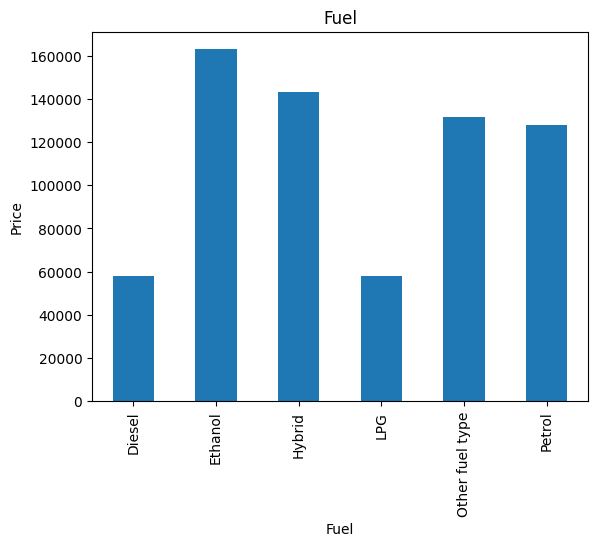

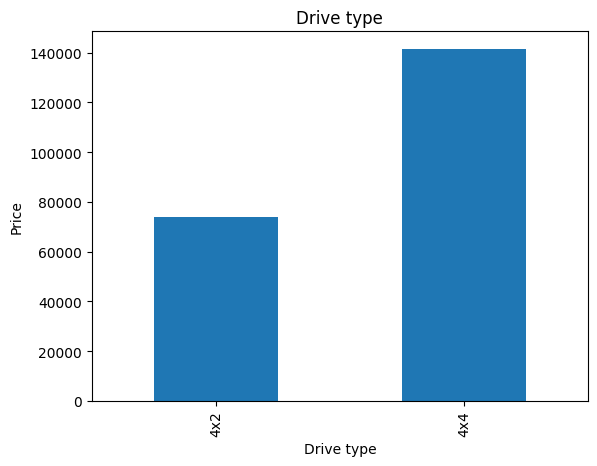

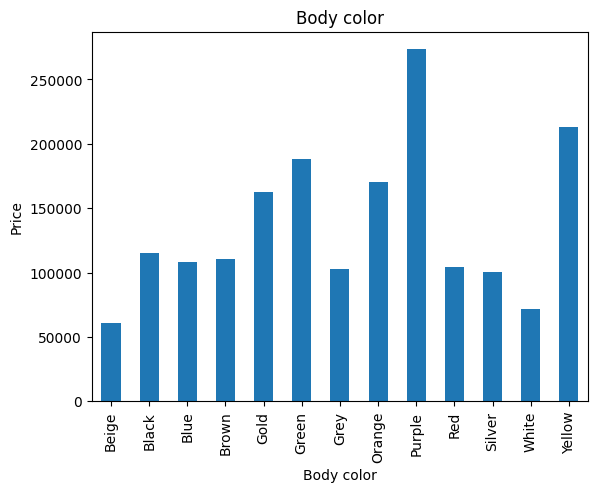

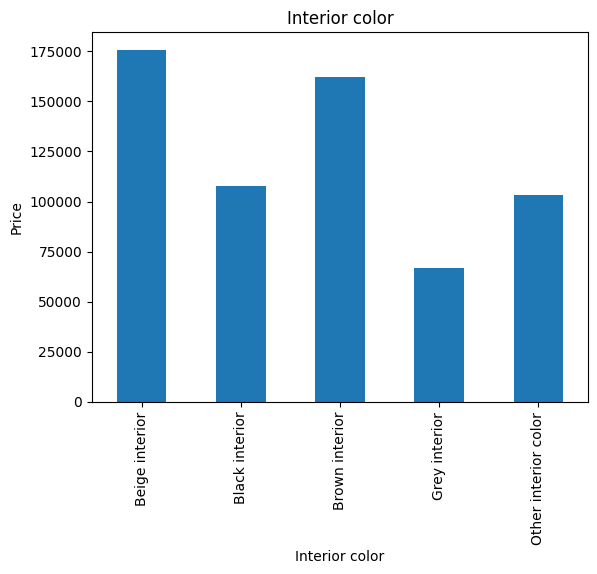

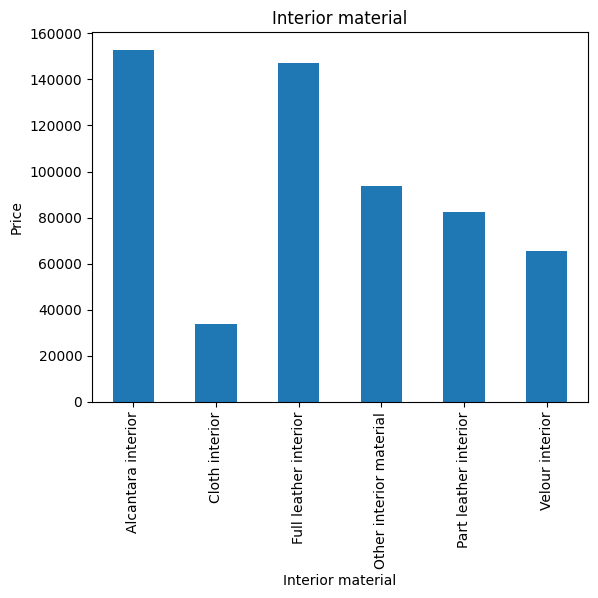

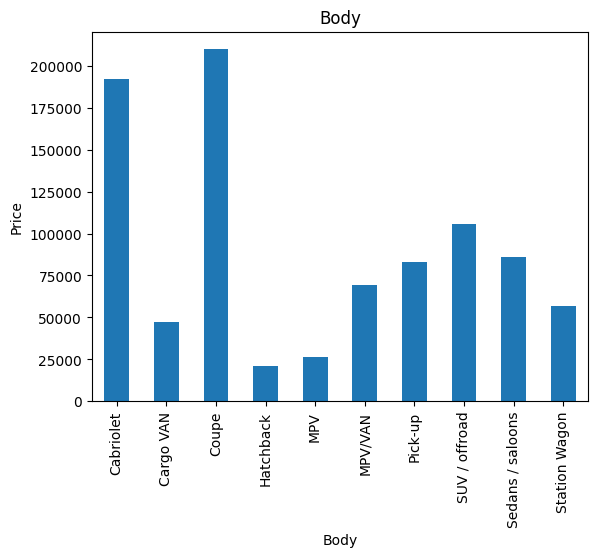

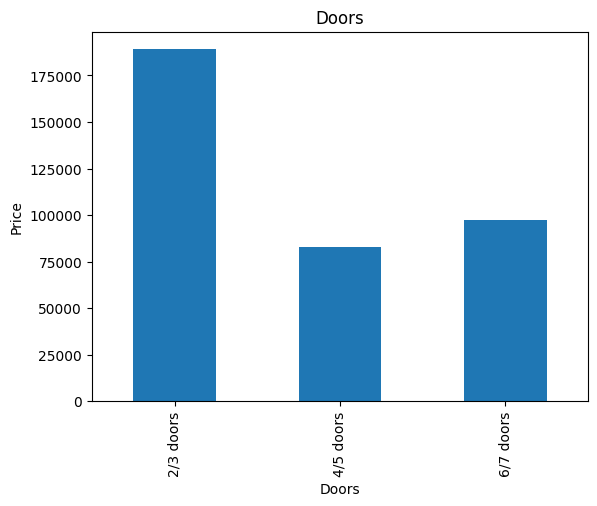

In [ ]:
excluded_columns = ['Make', 'Model']
filtered_features = [feature for feature in categorical_features if feature not in excluded_columns]

for feature in filtered_features:
    data = df.copy()
    data.groupby(feature)['Price'].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.title(feature)
    plt.show()

## 7 - Xử lý các giá trị bị khuyết

### 7.1. Category feature

In [ ]:
category_feature_nan = [feature for feature in categorical_features if df[feature].isnull().sum()>1]

for feature in category_feature_nan:
    print("{}: {}% missing values".format(feature,np.round(df[feature].isnull().mean(),4)))

Model: 0.0022% missing values
Body color: 0.0376% missing values
Interior color: 0.0622% missing values
Interior material: 0.0516% missing values
Doors: 0.0018% missing values


In [ ]:
# Replace missing value with new label

def replace_cat_feature(dataset,features_nan):
    data=dataset.copy()
    data[features_nan]=data[features_nan].fillna('Missing')
    return data

df=replace_cat_feature(df,category_feature_nan)

df[category_feature_nan].isnull().sum()

,0
Model,0
Body color,0
Interior color,0
Interior material,0
Doors,0


### 7.2. Numerical features

In [ ]:
numerical_features

['First registration',
 'Mileage',
 'Power',
 'Consumption',
 'CO2 emissions',
 'Seats']

In [ ]:
numerical_with_nan=[feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtypes!='O']

for feature in numerical_with_nan:
    print("{}: {}% missing values".format(feature,np.round(df[feature].isnull().mean(),4)))

Consumption: 0.162% missing values
CO2 emissions: 0.1446% missing values


#### 7.2.1. Consumption


Mean: 8.49461,
Median: 7.70000,
Mode: 12.10000


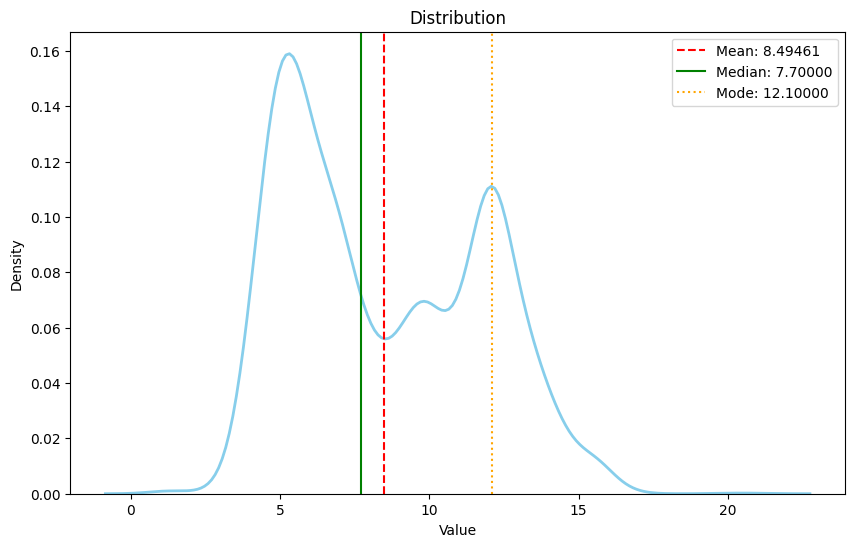

In [ ]:
# Tính toán mean, median, và mode bỏ qua giá trị null
mean = df['Consumption'].mean()
median = df['Consumption'].median()
mode = df['Consumption'].mode()[0] if not df.mode().empty else np.nan

# Hiển thị các giá trị thống kê
print(f"\nMean: {mean:.5f},\nMedian: {median:.5f},\nMode: {mode:.5f}")


# Vẽ biểu đồ KDE (line plot) để thể hiện phân phối mà không có các thanh
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Consumption'], color='skyblue', linewidth=2)
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.5f}')
plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.5f}')
plt.axvline(mode, color='orange', linestyle=':', label=f'Mode: {mode:.5f}')
# Thêm tiêu đề và nhãn
plt.title("Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

**Note:**
- Dựa vào Mean, Mode, Median và biểu đồ trên ta nhận thấy, biểu đồ có xu hướng lệch phải
- Do đó, điền Median cho các giá trị bị khuyết


Mean: 8.36588,
Median: 7.70000,
Mode: 7.70000


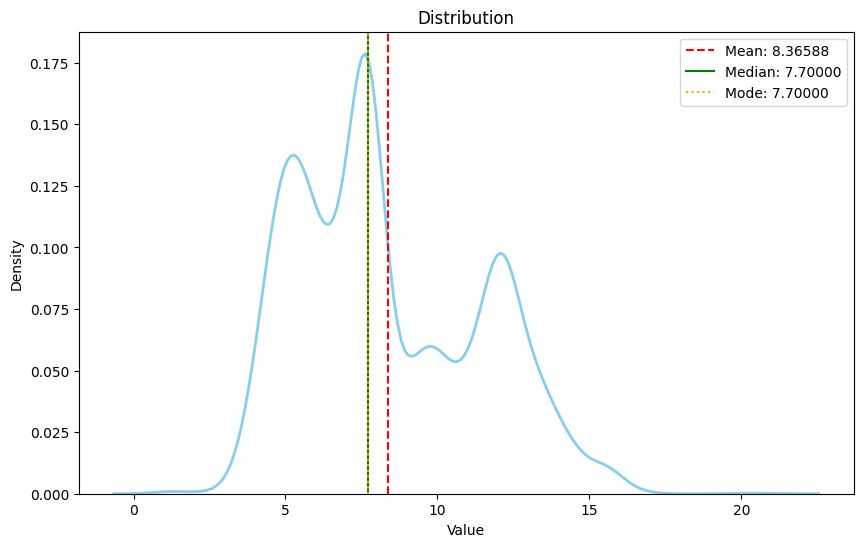

In [ ]:
df['Consumption'] = df['Consumption'].fillna(round(df['Consumption'].median(), 1))
# Tính toán mean, median, và mode bỏ qua giá trị null
mean = df['Consumption'].mean()
median = df['Consumption'].median()
mode = df['Consumption'].mode()[0] if not df.mode().empty else np.nan

# Hiển thị các giá trị thống kê
print(f"\nMean: {mean:.5f},\nMedian: {median:.5f},\nMode: {mode:.5f}")


# Vẽ biểu đồ KDE (line plot) để thể hiện phân phối mà không có các thanh
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Consumption'], color='skyblue', linewidth=2)
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.5f}')
plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.5f}')
plt.axvline(mode, color='orange', linestyle=':', label=f'Mode: {mode:.5f}')
# Thêm tiêu đề và nhãn
plt.title("Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

**Note:**
- Sau khi điền các giá trị bằng giá trị **Median**, ta thấy Mode = Median < Mean (nhưng không lệch quá 15%)
- Điều này cho thấy, điền **Median** cho các giá trị bị khuyết là hợp lý

#### 7.2.2. CO2 emissions


Mean: 196.43395,
Median: 187.00000,
Mode: 187.00000


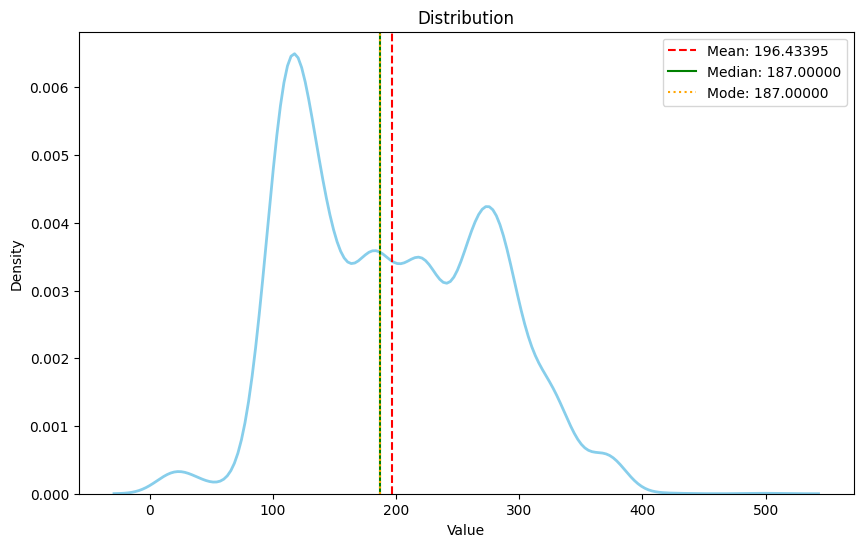

In [ ]:
# Tính toán mean, median, và mode bỏ qua giá trị null
mean = df['CO2 emissions'].mean()
median = df['CO2 emissions'].median()
mode = df['CO2 emissions'].mode()[0] if not df.mode().empty else np.nan

# Hiển thị các giá trị thống kê
print(f"\nMean: {mean:.5f},\nMedian: {median:.5f},\nMode: {mode:.5f}")


# Vẽ biểu đồ KDE (line plot) để thể hiện phân phối mà không có các thanh
plt.figure(figsize=(10, 6))
sns.kdeplot(df['CO2 emissions'], color='skyblue', linewidth=2)
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.5f}')
plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.5f}')
plt.axvline(mode, color='orange', linestyle=':', label=f'Mode: {mode:.5f}')
# Thêm tiêu đề và nhãn
plt.title("Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

**Note:**
- Nhìn vào đồ thị trên, ta thấy Median = Mode và nhỏ hơn Mean không đáng kể
- Do đó, điền Median cho các giá trị bị khuyết


Mean: 195.06980,
Median: 187.00000,
Mode: 187.00000


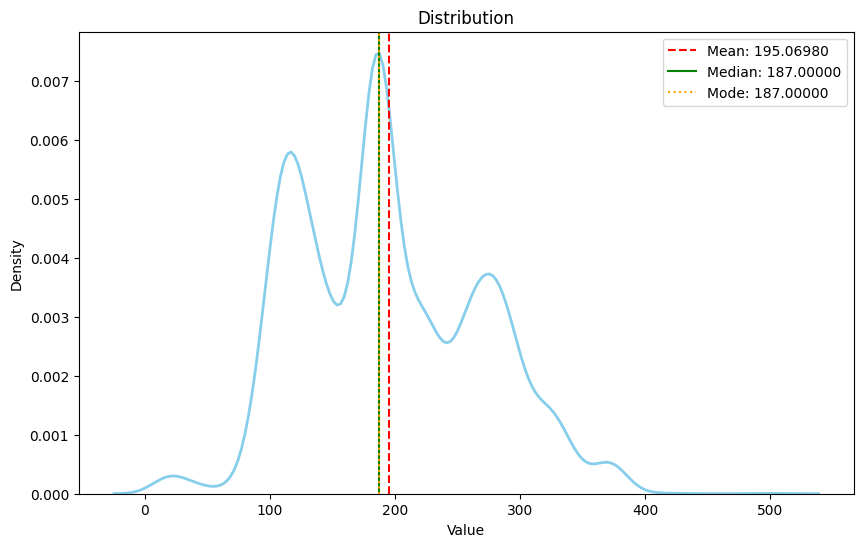

In [ ]:
df['CO2 emissions'] = df['CO2 emissions'].fillna(round(df['CO2 emissions'].median(), 1))

# Tính toán mean, median, và mode bỏ qua giá trị null
mean = df['CO2 emissions'].mean()
median = df['CO2 emissions'].median()
mode = df['CO2 emissions'].mode()[0] if not df.mode().empty else np.nan

# Hiển thị các giá trị thống kê
print(f"\nMean: {mean:.5f},\nMedian: {median:.5f},\nMode: {mode:.5f}")


# Vẽ biểu đồ KDE (line plot) để thể hiện phân phối mà không có các thanh
plt.figure(figsize=(10, 6))
sns.kdeplot(df['CO2 emissions'], color='skyblue', linewidth=2)
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.5f}')
plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.5f}')
plt.axvline(mode, color='orange', linestyle=':', label=f'Mode: {mode:.5f}')
# Thêm tiêu đề và nhãn
plt.title("Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

**Note:**
- Sau khi điền giá trị Mean, Mean ≈ Median ≈ Mode, cho thấy dữ liệu đã trở nên gần như đối xứng

In [ ]:
# Chuyển kiểu float64 về int64
df['CO2 emissions'] = df['CO2 emissions'].astype('int64')

In [ ]:
df.head(5)

,Make,Model,Location,First registration,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats,Price
0,Citroën,C5 Aircross,Spain,2023,27000,129,Automatic,Diesel,4x2,5.2,102,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors,5,22949.0
1,Nissan,X-Trail,Germany,2024,4500,211,Automatic,Petrol,4x4,6.5,146,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors,5,51649.0
2,Suzuki,SX4 S-Cross,Netherlands,2024,9393,127,Manual,Petrol,4x2,7.7,187,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,5,28449.0
3,Suzuki,Ignis,France,2020,13300,90,Manual,Petrol,4x2,4.7,107,Missing,Black interior,Other interior material,SUV / offroad,4/5 doors,4,15399.0
4,Peugeot,Rifter,Poland,2021,65140,129,Manual,Diesel,4x2,5.3,115,Grey,Missing,Missing,MPV/VAN,4/5 doors,7,30199.0


In [ ]:
df.to_csv('filled_data.csv', index=False)

## 8 - EDA after preprocessing

### 8.1 Feature engineer numerical variables

In [ ]:
continuous_feature

['Mileage', 'Power', 'Consumption', 'CO2 emissions']

In [ ]:
num_feature = ['Power', 'Consumption', 'CO2 emissions']

for feature in num_feature:
  df[feature]=np.log(df[feature])

In [ ]:
df.head()

,Make,Model,Location,First registration,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats,Price
0,Citroën,C5 Aircross,Spain,2023,27000,4.859812,Automatic,Diesel,4x2,1.648659,4.624973,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors,5,22949.0
1,Nissan,X-Trail,Germany,2024,4500,5.351858,Automatic,Petrol,4x4,1.871802,4.983607,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors,5,51649.0
2,Suzuki,SX4 S-Cross,Netherlands,2024,9393,4.844187,Manual,Petrol,4x2,2.041220,5.231109,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,5,28449.0
3,Suzuki,Ignis,France,2020,13300,4.499810,Manual,Petrol,4x2,1.547563,4.672829,Missing,Black interior,Other interior material,SUV / offroad,4/5 doors,4,15399.0
4,Peugeot,Rifter,Poland,2021,65140,4.859812,Manual,Diesel,4x2,1.667707,4.744932,Grey,Missing,Missing,MPV/VAN,4/5 doors,7,30199.0


### 8.2 ANOVA for category variables

In [ ]:
import scipy.stats as stats

categorical_features = ['Make',
 'Model',
 'Location',
 'Transmission',
 'Fuel',
 'Drive type',
 'Body color',
 'Interior color',
 'Interior material',
 'Body',
 'Doors']

for feature in categorical_features:
    # Group by the categorical feature and aggregate the 'Price' column into groups
    grouped_anova = df.groupby(feature)['Price'].apply(list)

    # Perform one-way ANOVA
    anova_result = stats.f_oneway(*grouped_anova)

    print(f"ANOVA result for {feature}: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

    alpha = 0.05  # Significance level
    # Evaluate the significance based on the p-value
    if anova_result.pvalue < alpha:
        print(f"{feature} is significant")
    else:
        print(f"{feature} is not significant")

ANOVA result for Make: F-statistic = 181.97755577078803, p-value = 0.0
Make is significant
ANOVA result for Model: F-statistic = 63.1552708863765, p-value = 0.0
Model is significant
ANOVA result for Location: F-statistic = 24.337434431314534, p-value = 1.9708942938452206e-45
Location is significant
ANOVA result for Transmission: F-statistic = 1037.5833016912904, p-value = 5.115435396026255e-207
Transmission is significant
ANOVA result for Fuel: F-statistic = 132.39443354904057, p-value = 3.914210987878645e-132
Fuel is significant
ANOVA result for Drive type: F-statistic = 754.9780145807274, p-value = 6.499296974990569e-155
Drive type is significant
ANOVA result for Body color: F-statistic = 33.453367799285196, p-value = 4.659321611465379e-81
Body color is significant
ANOVA result for Interior color: F-statistic = 34.71905755867804, p-value = 5.17968423684751e-35
Interior color is significant
ANOVA result for Interior material: F-statistic = 262.6614135575077, p-value = 6.81242895919021

In [ ]:
# Danh sách các feature phân loại
categorical_features = ['Make',
 'Model',
 'Location',
 'Transmission',
 'Fuel',
 'Drive type',
 'Body color',
 'Interior color',
 'Interior material',
 'Body',
 'Doors']

# Tạo một danh sách để lưu kết quả
anova_results = []

# Thực hiện ANOVA
for feature in categorical_features:
    # Group by the categorical feature and aggregate the 'Price' column into groups
    grouped_anova = df.groupby(feature)['Price'].apply(list)

    # Perform one-way ANOVA
    anova_result = stats.f_oneway(*grouped_anova)

    # Lưu kết quả vào danh sách
    anova_results.append({
        'Feature': feature,
        'F-statistic': anova_result.statistic,
        'p-value':  anova_result.pvalue,
        'Significant': anova_result.pvalue < 0.05  # Đánh giá tính quan trọng
    })

# Chuyển danh sách thành DataFrame
anova_df = pd.DataFrame(anova_results)

anova_df_sorted = anova_df.sort_values(by='F-statistic', ascending=False).reset_index()
anova_df_sorted = anova_df_sorted.drop('index', axis=True)
anova_df_sorted

,Feature,F-statistic,p-value,Significant
0,Transmission,1037.583302,5.115435e-207,True
1,Drive type,754.978015,6.499297e-155,True
2,Doors,515.835820,5.040267e-292,True
3,Body,339.967263,0.000000e+00,True
4,Interior material,262.661414,6.812429e-293,True
5,Make,181.977556,0.000000e+00,True
6,Fuel,132.394434,3.914211e-132,True
7,Model,63.155271,0.000000e+00,True
8,Interior color,34.719058,5.179684e-35,True
9,Body color,33.453368,4.659322e-81,True


### 8.3 Correlation for numerical variables

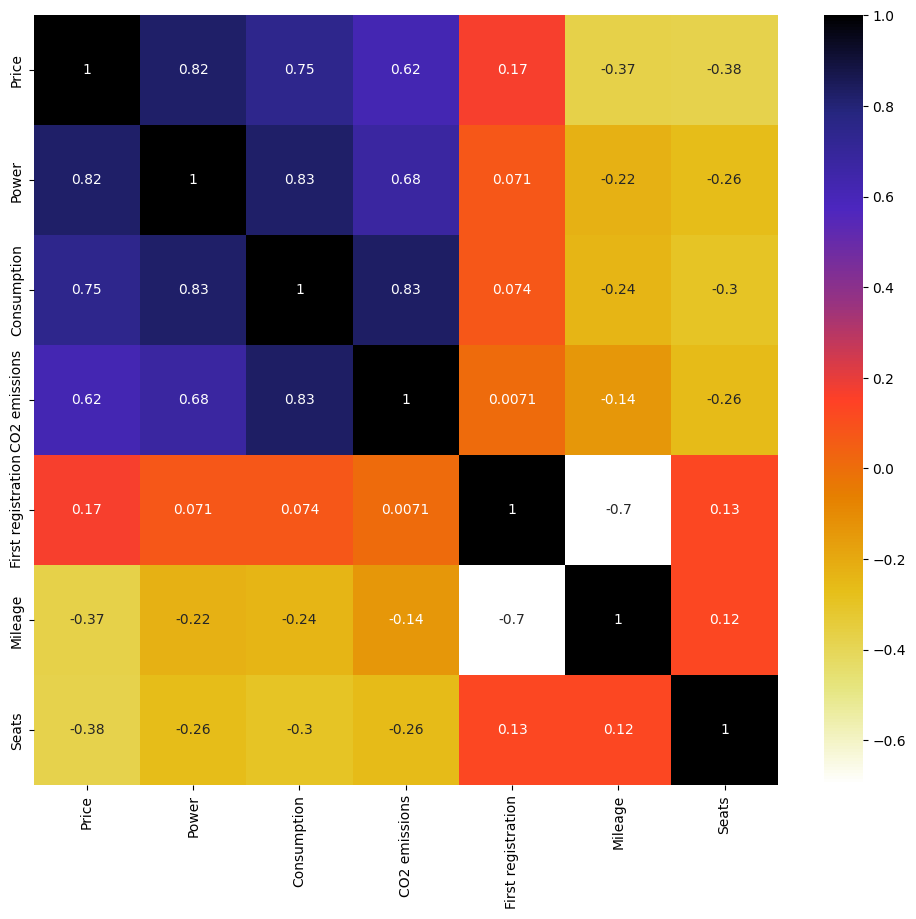

In [ ]:
num_feature = ['Price', 'Power', 'Consumption', 'CO2 emissions', 'First registration', 'Mileage', 'Seats']

# Assuming 'num_feature' is a list of numerical features in your DataFrame 'df'
plt.figure(figsize=(12, 10))
cor = df[num_feature].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

### 8.4. Feature Scaling

In [ ]:
feature_scale = ['Power', 'Consumption', 'CO2 emissions', 'Mileage', 'Seats']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(df[feature_scale])

MinMaxScaler()

In [ ]:
df[feature_scale] = scaler.transform(df[feature_scale])

df.head()

,Make,Model,Location,First registration,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats,Price
0,Citroën,C5 Aircross,Spain,2023,0.154286,0.604243,Automatic,Diesel,4x2,0.542367,0.546980,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors,0.6,22949.0
1,Nissan,X-Trail,Germany,2024,0.025714,0.711176,Automatic,Petrol,4x4,0.615775,0.649314,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors,0.6,51649.0
2,Suzuki,SX4 S-Cross,Netherlands,2024,0.053674,0.600847,Manual,Petrol,4x2,0.671509,0.719937,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,0.6,28449.0
3,Suzuki,Ignis,France,2020,0.076000,0.526005,Manual,Petrol,4x2,0.509109,0.560636,Missing,Black interior,Other interior material,SUV / offroad,4/5 doors,0.4,15399.0
4,Peugeot,Rifter,Poland,2021,0.372229,0.604243,Manual,Diesel,4x2,0.548633,0.581210,Grey,Missing,Missing,MPV/VAN,4/5 doors,1.0,30199.0


In [ ]:
df.head()

,Make,Model,Location,First registration,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats,Price
0,Citroën,C5 Aircross,Spain,2023,0.154286,0.604243,Automatic,Diesel,4x2,0.542367,0.546980,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors,0.6,22949.0
1,Nissan,X-Trail,Germany,2024,0.025714,0.711176,Automatic,Petrol,4x4,0.615775,0.649314,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors,0.6,51649.0
2,Suzuki,SX4 S-Cross,Netherlands,2024,0.053674,0.600847,Manual,Petrol,4x2,0.671509,0.719937,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,0.6,28449.0
3,Suzuki,Ignis,France,2020,0.076000,0.526005,Manual,Petrol,4x2,0.509109,0.560636,Missing,Black interior,Other interior material,SUV / offroad,4/5 doors,0.4,15399.0
4,Peugeot,Rifter,Poland,2021,0.372229,0.604243,Manual,Diesel,4x2,0.548633,0.581210,Grey,Missing,Missing,MPV/VAN,4/5 doors,1.0,30199.0


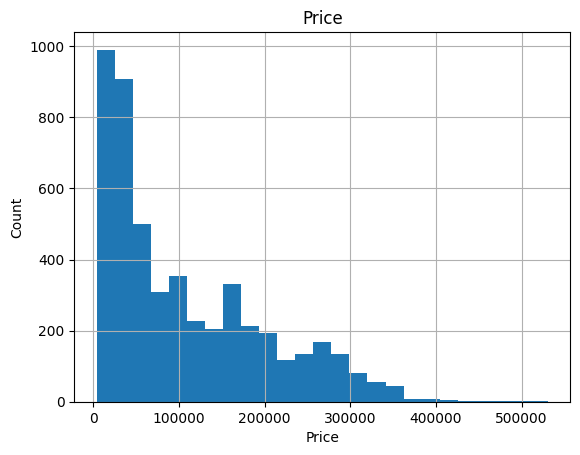

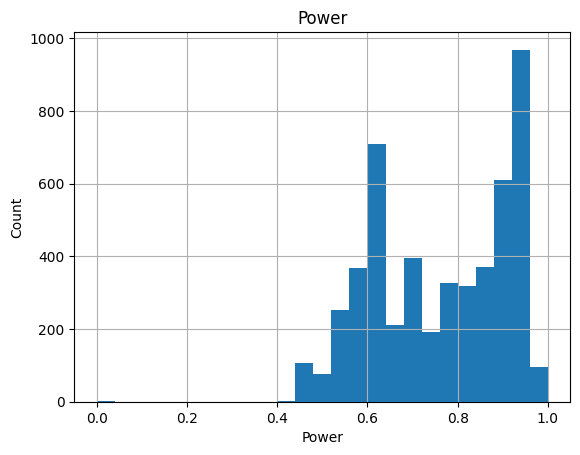

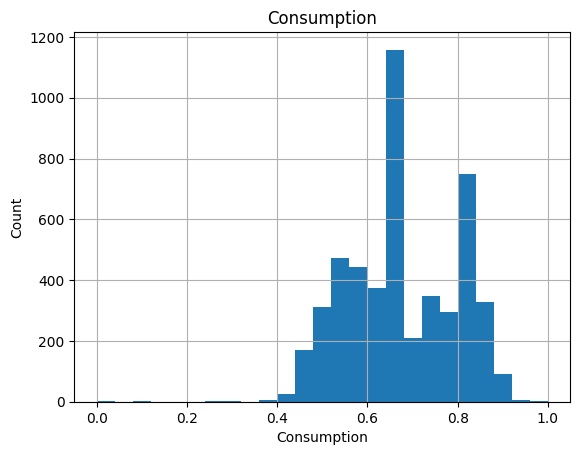

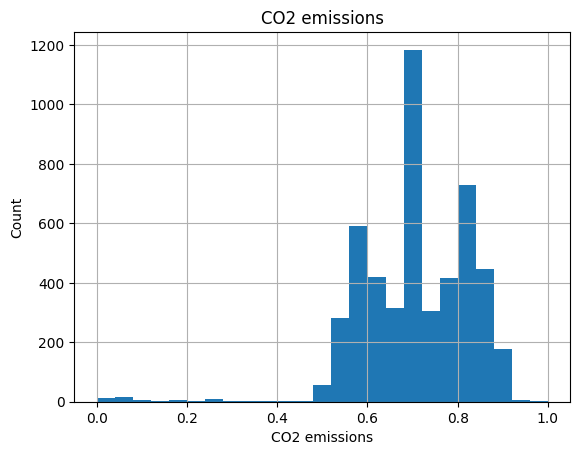

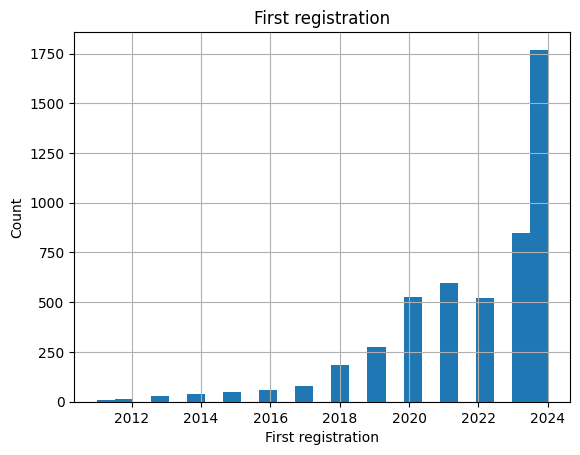

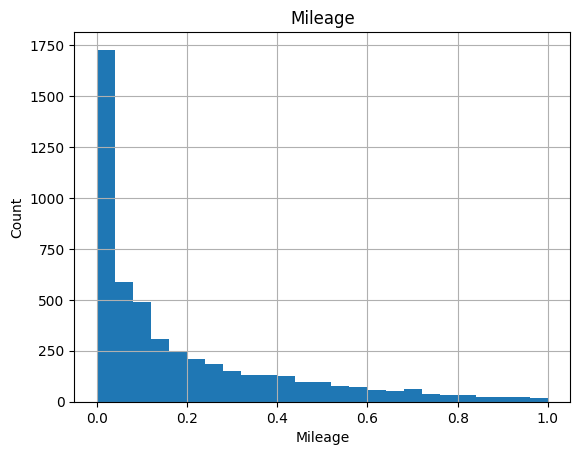

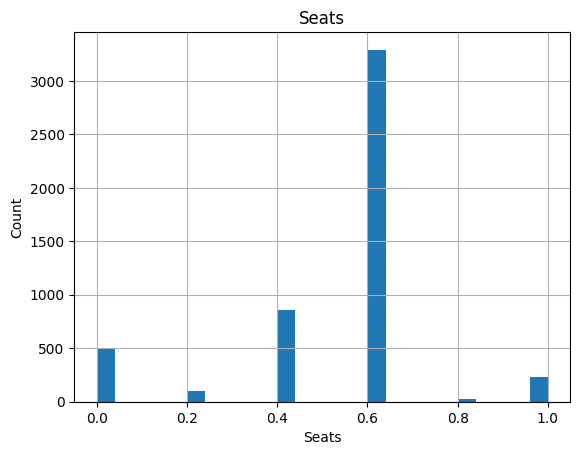

In [ ]:
for feature in num_feature:
    data=df.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [ ]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=False, dtype=int)

In [ ]:
df = df.drop(['First registration'], axis=1, errors='ignore')

In [ ]:
df.head()

,Mileage,Power,Consumption,CO2 emissions,Seats,Price,Make_Abarth,Make_Aixam,Make_Alfa Romeo,Make_Alpina,...,Body_MPV,Body_MPV/VAN,Body_Pick-up,Body_SUV / offroad,Body_Sedans / saloons,Body_Station Wagon,Doors_2/3 doors,Doors_4/5 doors,Doors_6/7 doors,Doors_Missing
0,0.154286,0.604243,0.542367,0.546980,0.6,22949.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0.025714,0.711176,0.615775,0.649314,0.6,51649.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.053674,0.600847,0.671509,0.719937,0.6,28449.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0.076000,0.526005,0.509109,0.560636,0.4,15399.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.372229,0.604243,0.548633,0.581210,1.0,30199.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 616 entries, Mileage to Doors_Missing
dtypes: float64(6), int64(610)
memory usage: 23.5 MB


In [ ]:
df.to_csv('processed_data.csv', index=False)

# Part 3 - Model

In [1]:
# Để quản lý dữ liệu trong dataframe
import pandas as pd
import numpy as np
# Để vẽ các loại biểu đồ
import matplotlib.pyplot as plt
# Để tạo các pipeline xử lý dữ liệu và mô hình hồi quy
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

# Import các mô hình hồi quy từ thư viện scikit-learn và các thư viện bổ sung
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
# Import các hàm và lớp cần thiết cho việc chia dữ liệu và tìm siêu tham số
from sklearn.model_selection import (KFold,
                                     train_test_split,
                                     GridSearchCV, cross_val_score)
# Import các độ đo đánh giá mô hình hồi quy
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score)


## 1 - Đọc dữ liệu

In [2]:
# Đặt đường dẫn tới tệp CSV chứa dữ liệu đã được làm sạch
path = "processed_data.csv" #Min Max Scaler

df = pd.read_csv(path)

In [3]:
df.head()

,Mileage,Power,Consumption,CO2 emissions,Seats,Price,Make_Abarth,Make_Aixam,Make_Alfa Romeo,Make_Alpina,...,Body_MPV,Body_MPV/VAN,Body_Pick-up,Body_SUV / offroad,Body_Sedans / saloons,Body_Station Wagon,Doors_2/3 doors,Doors_4/5 doors,Doors_6/7 doors,Doors_Missing
0,0.154286,0.604243,0.542367,0.546980,0.6,22949.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0.025714,0.711176,0.615775,0.649314,0.6,51649.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.053674,0.600847,0.671509,0.719937,0.6,28449.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0.076000,0.526005,0.509109,0.560636,0.4,15399.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.372229,0.604243,0.548633,0.581210,1.0,30199.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 2 - Train test split

In [4]:
# Chia tập dữ liệu thành đặc trưng đầu vào và đầu ra
y = df['Price'].values

X = df.drop(columns=['Price']).values

# In kích thước
print(f"Kích thước X: {X.shape}")
print(f"Kích thước y: {y.shape}")

Kích thước X: (5000, 615)
Kích thước y: (5000,)


In [5]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử với tỷ lệ kiểm thử là 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In kích thước tập huấn luyện
print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước y_train: {y_train.shape}\n")

# In kích thước tập kiểm thử
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_test: {y_test.shape}")

Kích thước X_train: (4000, 615)
Kích thước y_train: (4000,)

Kích thước X_test: (1000, 615)
Kích thước y_test: (1000,)


### 2.1. Mô hình Linear Regression

**Note:**
- Do số cột sau khi OneHotEncoder lên đến 615 cột
- Nên máy tính cá nhân và colab chỉ chạy được Linear với bậc = 1

In [8]:
# Khởi tạo các biến để lưu trữ kết quả
best_degree = None
best_score = float('-inf')
results = []

# Thử các bậc từ 1 đến 2
for degree in range(1, 2):
    # Tạo pipeline với Polynomial Features và Linear Regression
    pipeline = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('linear_regression', LinearRegression())
    ])

    # Huấn luyện mô hình trên tập train
    pipeline.fit(X_train, y_train)

    # Dự đoán trên tập test
    y_pred = pipeline.predict(X_test)

    # Tính các độ đo
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Ghi lại kết quả
    results.append((degree, r2, mae, mse))

    # Cập nhật bậc tốt nhất dựa trên R²
    if r2 > best_score:
        best_degree = degree
        best_score = r2

In [ ]:
# Hiển thị kết quả

for degree, r2, mae, mse in results:
    print(f"Linear Regression (degree = 1) | {r2:.5f} | {mae:.5f} | {mse:.5f} ")



Linear Regression (degree = 1) | 0.88961 | 22170.31616 | 956741143.22748 


### 2.2 Các mô hình khác

In [ ]:
# Xây dựng pipeline chỉ với mô hình hồi quy
regression_models = {
    'XGBoost': XGBRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'HistogramGradientBoosting': HistGradientBoostingRegressor(random_state=42),
}

In [ ]:
# Danh sách tên các mô hình hồi quy
regression_model_names = ['XGBoost',  'DecisionTree', 'RandomForest', 'HistogramGradientBoosting']
# Dictionary để lưu trữ tất cả các pipeline
all_pipelines = {}
# Duyệt qua danh sách tên mô hình và tạo pipeline cho mỗi mô hình
for model_name in regression_model_names:
    # Sử dụng hàm create_regression_pipeline để tạo pipeline cho mô hình hiện tại
    regression_pipeline = Pipeline(steps=[
        ('regressor', regression_models[model_name])
    ])
    # Tạo dictionary với key là tên pipeline và value là pipeline tương ứng
    pipeline_dict = {model_name: regression_pipeline}
    # Cập nhật vào dictionary lớn
    all_pipelines.update(pipeline_dict)

In [ ]:
results_df = pd.DataFrame(columns=['Mô hình', 'MSE', 'MAE', 'R2'])

    # Duyệt qua danh sách các mô hình và thực hiện huấn luyện và đánh giá
for model_name, pipeline in all_pipelines.items():
    # Huấn luyện mô hình
    pipeline.fit(X_train, y_train)

    # Dự đoán trên dữ liệu kiểm thử
    y_pred = pipeline.predict(X_test)

    # Đánh giá hiệu suất của mô hình
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Tạo DataFrame từ kết quả và concatenate vào DataFrame kết quả chung.
    model_results = pd.DataFrame(
    {'Mô hình': [model_name],
     'MSE': [ f'{mse:.3f}'],
     'MAE': [f'{mae:.3f}'],
     'R2': [f'{r2:.3f}']})
    results_df = pd.concat([results_df, model_results], ignore_index=True)
    # Sắp xếp DataFrame theo thứ tự giảm dần của R2.
    results_df = results_df.sort_values(
        by='R2', ascending=False).reset_index(drop=True)

In [ ]:
results_df

,Mô hình,MSE,MAE,R2
0,XGBoost,492416589.018,13707.594,0.943
1,HistogramGradientBoosting,505920218.740,13731.157,0.942
2,RandomForest,528170078.124,13252.834,0.939
3,DecisionTree,881261960.347,16991.575,0.898


In [ ]:
# Hiển thị kết quả
for degree, r2, mae, mse in results:
    print(f"Linear Regression (degree = 1)   | {mse:.5f} | {mae:.5f} | {r2:.5f}")


Linear Regression (degree = 1)   | 956741143.22748 | 22170.31616 | 0.88961


Dựa trên kết quả tìm được, ta có thể thấy rằng mô hình XGBoost cho ra giá trị của các độ đo MSE, MAE và R2 là cao nhất. Do đó, đây là mô hình tối ưu nhất cho bộ dữ liệu tìm được.

## 3 - K-fold

In [10]:
# Tạo danh sách mô hình
regression_models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'HistogramGradientBoosting': HistGradientBoostingRegressor(random_state=42),
}

In [11]:
# Dictionary để lưu trữ tất cả các pipeline
all_pipelines = {}

regression_model_names = ['LinearRegression',  'DecisionTree', 'RandomForest', 'HistogramGradientBoosting', 'XGBoost']

# Tạo pipeline cho từng mô hình
for model_name in regression_model_names:
    regression_pipeline = Pipeline(steps=[
        ('regressor', regression_models[model_name])
    ])
    all_pipelines[model_name] = regression_pipeline

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

result_df = pd.DataFrame(columns=['Model', 'Mean_R2'])
result_list = []
# Huấn luyện và đánh giá từng pipeline
for model_name, pipeline in all_pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')  # Sử dụng R^2 làm thước đo
    mean_r2 = np.mean(scores)  # Tính trung bình R^2

    # Lưu kết quả vào DataFrame
    result_list.append({'Model': model_name, 'Mean_R2': mean_r2})

result_df = pd.concat([result_df, pd.DataFrame(result_list)], ignore_index=True)


<ipython-input-12-d7d54f8daa00>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame(result_list)], ignore_index=True)


In [27]:
result_df

,Model,Mean_R2
0,LinearRegression,0.899922
1,DecisionTree,0.895528
2,RandomForest,0.939124
3,HistogramGradientBoosting,0.939971
4,XGBoost,0.944342


## 3. Fine tuning cho XGBoost

In [7]:
# Initial XGBoost model
xgb = XGBRegressor(tree_method="gpu_hist", random_state=42)


# Parameter grid for GridSearch
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [8]:
# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:04:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
Best Score: -465494262.28818387


In [9]:
# Tạo một XGBRegressor với các tham số mặc định
xgb_res = XGBRegressor()

# Huấn luyện XGBRegressor trên dữ liệu huấn luyện
# và đưa ra dự đoán trên dữ liệu kiểm thử
xgb_res.fit(X_train, y_train)
y_pred = xgb_res.predict(X_test)

# In các độ đo đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 492416589.018
Mean Absolute Error (MAE): 13707.594
R-squared (R2) Score: 0.943


In [6]:
xgb = XGBRegressor(
    colsample_bytree=0.9,
    gamma=0,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    n_estimators=300,
    subsample=0.8,
    random_state=42  # optional for reproducibility
)

In [7]:
# Example usage: Fit the model to your training data
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# In các độ đo đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 457971052.652
Mean Absolute Error (MAE): 13198.638
R-squared (R2) Score: 0.947


# Part 4 - Mô hình XGBoost

In [8]:
import pandas as pd 
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor  # XGBoost Regressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# Import các hàm và lớp cần thiết cho việc chia dữ liệu và tìm siêu tham số
from sklearn.model_selection import train_test_split
# Import các độ đo đánh giá mô hình hồi quy
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score)

import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
df = pd.read_csv('filled_data.csv')

In [11]:
df.head()

,Make,Model,Location,First registration,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats,Price
0,Citroën,C5 Aircross,Spain,2023,27000,129,Automatic,Diesel,4x2,5.2,102,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors,5,22949.0
1,Nissan,X-Trail,Germany,2024,4500,211,Automatic,Petrol,4x4,6.5,146,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors,5,51649.0
2,Suzuki,SX4 S-Cross,Netherlands,2024,9393,127,Manual,Petrol,4x2,7.7,187,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,5,28449.0
3,Suzuki,Ignis,France,2020,13300,90,Manual,Petrol,4x2,4.7,107,4/5 doors,Black interior,Other interior material,SUV / offroad,4/5 doors,4,15399.0
4,Peugeot,Rifter,Poland,2021,65140,129,Manual,Diesel,4x2,5.3,115,Grey,4/5 doors,4/5 doors,MPV/VAN,4/5 doors,7,30199.0


In [12]:
df.isna().sum()

Make                  0
Model                 0
Location              0
First registration    0
Mileage               0
Power                 0
Transmission          0
Fuel                  0
Drive type            0
Consumption           0
CO2 emissions         0
Body color            0
Interior color        0
Interior material     0
Body                  0
Doors                 0
Seats                 0
Price                 0
dtype: int64

In [13]:
X = df.drop(columns=['Price', 'First registration'])
y = df['Price']

In [14]:
X[0:5]

,Make,Model,Location,Mileage,Power,Transmission,Fuel,Drive type,Consumption,CO2 emissions,Body color,Interior color,Interior material,Body,Doors,Seats
0,Citroën,C5 Aircross,Spain,27000,129,Automatic,Diesel,4x2,5.2,102,Black,Other interior color,Other interior material,SUV / offroad,4/5 doors,5
1,Nissan,X-Trail,Germany,4500,211,Automatic,Petrol,4x4,6.5,146,Grey,Black interior,Cloth interior,SUV / offroad,4/5 doors,5
2,Suzuki,SX4 S-Cross,Netherlands,9393,127,Manual,Petrol,4x2,7.7,187,Silver,Other interior color,Full leather interior,SUV / offroad,4/5 doors,5
3,Suzuki,Ignis,France,13300,90,Manual,Petrol,4x2,4.7,107,4/5 doors,Black interior,Other interior material,SUV / offroad,4/5 doors,4
4,Peugeot,Rifter,Poland,65140,129,Manual,Diesel,4x2,5.3,115,Grey,4/5 doors,4/5 doors,MPV/VAN,4/5 doors,7


In [15]:
y[0:5]

0    22949.0
1    51649.0
2    28449.0
3    15399.0
4    30199.0
Name: Price, dtype: float64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Xác định các cột numerical và categorical
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [18]:
print(num_features)
print(cat_features)

['Mileage', 'Power', 'Consumption', 'CO2 emissions', 'Seats']
['Make', 'Model', 'Location', 'Transmission', 'Fuel', 'Drive type', 'Body color', 'Interior color', 'Interior material', 'Body', 'Doors']


In [19]:
# Xử lý giá trị khuyết và xử lý dữ liệu
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Điền giá trị khuyết bằng trung bình
            ('scaler', MinMaxScaler())  # Chuẩn hóa các biến số
        ]), num_features),
        
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Điền giá trị khuyết bằng giá trị phổ biến nhất
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoder để xử lý các biến phân loại
        ]), cat_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
                            colsample_bytree = 0.9,
                            gamma = 0,
                            learning_rate = 0.1,
                            max_depth = 5,
                            min_child_weight = 3,
                            n_estimators = 300,
                            subsample = 0.8,
                            random_state = 42
                            ))
])


In [20]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Mileage', 'Power',
                                                   'Consumption',
                                                   'CO2 emissions', 'Seats']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Make', 'Model', 'Locat...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

In [21]:
y_pred = model_pipeline.predict(X_test)

In [22]:
# In các độ đo đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 466275763.206
Mean Absolute Error (MAE): 13073.262
R-squared (R2) Score: 0.946


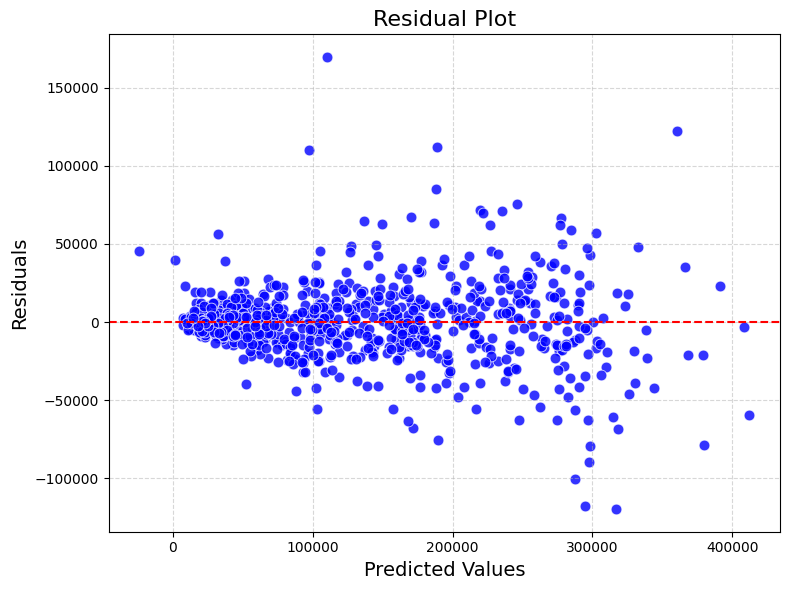

In [23]:
# Tính residuals
residuals = y_test - y_pred

# Vẽ biểu đồ residuals
plt.figure(figsize=(8, 6))

# Scatter plot
sns.scatterplot(x=y_pred, y=residuals, color='blue', s=60, alpha=0.8)

# Đường ngang tại residual = 0
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Thêm thông tin biểu đồ
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()


In [24]:
joblib.dump(model_pipeline, 'model_xgboost.pkl')

['model_xgboost.pkl']